In [15]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Disease Categories and associated variants per Deep Phenotyping Paper

Source: https://www.pnas.org/doi/10.1073/pnas.1909378117

In [16]:
# Autosomal Dominant and Autosomal Recessive diseases identified in the paper
AD = ['CHEK2', 'MYBPC3', 'BRCA2', 'ATM', 'HOXB13', 'LDLR']
AR = ['HFE', 'BTD','GJB2']
# Dyslipedemia
DYS = ['ANGPTL4', 'APOB', 'APOC3', 'LDLR', 'LPL','MEF2A','NPC1L1', 'PAFAH1B2', 'PCSK9']
# Cardiomyopathy and Arrythmia
CM_AR = ['ANK2', 'DSC2', 'ENG', 'GPD1L', 'KCNE2', 'KCNQ1', 'LMNA', 'MYBPC3' , 'MYH7', 'MYL2', 'MYLK', 'PKP2', 'RBM20', 'RYR2', 'SCN1B', 'SMAD6', 'TCAP', 'TNT2', 'TTN', 'TTR', 'VCL']
# Diabetes and Endocrine
DB_EN = ["ABCC8", "FAAH", "GLMN", "HNF1A", "HNF1B", "INSR", "MC4R", "NEUROD1", "NOBOX", "NR3C1", "PCSK1", "PPPIR3A", "PROK2", "TBC1D4"]
# Chronic Liver Disease
CLD = ['HFE']
# Cancer
cancer = ["APC", "ATM", "BARD1", "BRCA1", "BRCA2", "BRIP1", "CHEK2", "CYLD", "EPCAM", "FAM175A", "FH", "GEN1", "GLMN", "HOXB13", "LZTR1", "MSH6", "NBN", "NF1", "PALB2", "PMS1", "PMS2", "RAD50", "RAD51C", "RB1", "RECQL", "TP53"]
# Immunological, Neurological & Other Diseases
IM_NE_O = ["CFHR5", "COL9A1", "CYP21A2", "DNAH5", "FCGR1A", "FLG", "GJB2", "GRN", "KIDINS220", "LRP5", "LRRK2", "MATN3", "MS4A2", "MY015A", "NMNAT1", "PKD1", "PRPF31", "RAPSN", "R1", "RYR1", "SCN1A", "SERPINA1", "SGCE", "SNCA", "TGM6", "TNFRSF13B", "WFS1"]
# Hematological Diseases
HEM = ["CPOX", "EGLN1", "F11", "G6PD", "HBB", "ITGB3", "PROC"]
# Inborn Errors of Metabolism
IEM = ["BTD", "FMO3", "DMGDH", "SLC22A5"]

dict_of_gene_lists = {'AD': AD, 'AR': AR, 'DYS':DYS, 'CM_AR': CM_AR, 'DB_EN': DB_EN, 'CLD': CLD, 'cancer':cancer,
                     'IM_NE_O': IM_NE_O, 'HEM':HEM, 'IEM':IEM  }

In [17]:
### Get phenotypes for disease category from medical records in OMOP CDM ###
def run_cohort_query(cohort_id, inclusion_codes):
    def get_password(txt_path):
        with open(txt_path,'r') as f:
            for line in f:
                password=line.strip('\n')
        return password
                
    password=get_password('/Users/jerenolsen/Desktop/password.txt')
                    
    db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "etl-testing",
    "user": "postgres",
    "password": "{password}".format(password=password)
    }
    
    query = """
    SELECT combined_table.*, p.person_source_value
    FROM (
        SELECT person_id, condition_source_value AS val, condition_concept_id as concept_id
        FROM cdm.condition_occurrence
        UNION ALL
        SELECT person_id, observation_source_value AS val, observation_concept_id as concept_id
        FROM cdm.observation
    ) AS combined_table
    JOIN cdm.person p ON combined_table.person_id = p.person_id
    WHERE combined_table.person_id IN (
        SELECT subject_id FROM results.cohort WHERE cohort_definition_id = {cohort_id}
    )
    AND combined_table.concept_id IN ({inclusion_codes});""".format(cohort_id=cohort_id, inclusion_codes=','.join(map(str, inclusion_codes)))
    
    try:

        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        cursor.execute(query)
        data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]

        df = pd.DataFrame(data, columns=column_names)

        cursor.close()
        connection.close()
        
        return df

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL or executing query:", error)
        return None
    

In [18]:
def get_phenotype_df(cohort_query_df):
    df_pheno = pd.DataFrame.from_dict({'person_source_value':cohort_query_df['person_source_value'].unique().tolist()})
    return df_pheno

def get_category_vars_df(all_study_vars, genes_list):
    # All Occurences of variants of disease category in HVD PGP Population
    geno_mapping = {'1/0': 'heterozygous alt', '0/1': 'heterozygous alt', '1/1': 'homozygous alt'}
    
    category_vars = all_study_vars[all_study_vars['GeneSymbol'].isin(genes_list)]
    category_vars.reset_index(drop=True,inplace=True)
    category_vars['genotype'] = category_vars['genotype'].map(geno_mapping)
    
    return category_vars


def get_genes_and_variants(category_vars):
    genes = dict(category_vars['GeneSymbol'].value_counts())
    
    genes_and_variants = {}
    
    for gene in genes.keys():
        var_df = category_vars[category_vars['GeneSymbol'] == gene]  # Use gene-specific DataFrame
        gene_variants = {}  # Initialize dictionary for gene's variants

        variants = dict(var_df['names'].value_counts())  # Use var_df for each gene
        for variant in variants.keys():
            genotypes = dict(var_df[var_df['names'] == variant]['genotype'].value_counts())
            gene_variants[variant] = genotypes

        genes_and_variants[gene] = gene_variants
        
            
    return genes_and_variants


In [19]:
### Plotting ###

def create_gene_variants_heatmap(genes_and_variants:dict, disease_category):
    heatmap_data = []

    for gene, variants in genes_and_variants.items():
        for variant, genotypes in variants.items():
            row = {'Gene': gene, 'Variant': variant, **genotypes}
            heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data).fillna(0)
    heatmap_df.set_index(['Gene', 'Variant'], inplace=True)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, cmap='YlGnBu', annot=True, fmt='g')
    plt.title(f'All MSF Genotype Counts for {disease_category} Disease Category')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
def flatten_genes_and_variants(genes_and_variants_dict):
    data = genes_and_variants_dict
    gene_symbols = []
    variant_names = []
    heterozygous_alt_counts = []
    homozygous_alt_counts = []

    for gene_symbol, variants in data.items():
        for variant_name, counts in variants.items():
            gene_symbols.append(gene_symbol)
            variant_names.append(variant_name)
            heterozygous_alt_counts.append(counts.get('heterozygous alt', 0))
            homozygous_alt_counts.append(counts.get('homozygous alt', 0))

    df = pd.DataFrame({
        'GeneSymbol': gene_symbols,
        'names': variant_names,
        'heterozygous alt count': heterozygous_alt_counts,
        'Homozygous alt count': homozygous_alt_counts
    })
    return df

def plot_manifest_percentages(df_all, disease_category):
    df = df_all

    df['percent het w/pheno manifest'].fillna(0, inplace=True)
    df['percent homo w/pheno manifest'].fillna(0, inplace=True)

    clusters = df[['GeneSymbol', 'percent het w/pheno manifest', 'percent homo w/pheno manifest']]

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(clusters))
    bar_width = 0.4

    # Create the bars for percentage values
    het_bars = ax.bar(x - bar_width/2, clusters['percent het w/pheno manifest'], bar_width, label='Percent Het Alt')
    homo_bars = ax.bar(x + bar_width/2, clusters['percent homo w/pheno manifest'], bar_width, label='Percent Homo Alt')

    ax.set_xticks(x)
    ax.set_xticklabels(clusters['GeneSymbol'])
    ax.set_xlabel('Gene Symbol')
    ax.set_ylabel('Percent of genotypes with associated phenotype')

    ax.legend()
    ax.set_title(f'Percent of MSF Variants with Associated {disease_category} Phenotype Manifestation')

    plt.tight_layout()
    plt.show()
    

In [20]:
### Run analysis pipeline for given disease category ###
def run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes):
    df = run_cohort_query(cohort_id, inclusion_codes = all_inclusion_codes)

    df_pheno = get_phenotype_df(cohort_query_df = df)

    study_vars_category = get_category_vars_df(all_study_vars,disease_category_genes)
    genes_and_variants = get_genes_and_variants(study_vars_category)
    print(f"All variants for {disease_category}:\n {genes_and_variants}\n")

    pheno_manifest = df_pheno.merge(study_vars_category, left_on = 'person_source_value', right_on = 'sample_name', suffixes=('', ''))
    genes_and_variants_manifest = get_genes_and_variants(pheno_manifest)
    print(f"All variants with phenotype manifestation for {disease_category}:\n {genes_and_variants_manifest}\n")

    df_all = flatten_genes_and_variants(genes_and_variants)
    df_manifest = flatten_genes_and_variants(genes_and_variants_manifest)
    df_all['percent het w/pheno manifest'] = df_manifest[['heterozygous alt count']].div(df_all['heterozygous alt count'], axis=0)
    df_all['percent homo w/pheno manifest'] = df_manifest[['Homozygous alt count']].div(df_all['Homozygous alt count'], axis=0)
    
    return genes_and_variants, df_all

## Load Harvard PGP Variants taken from Google Big Query and merged with Clinvar medically significant variant info (all MSF Variants)

In [29]:
path = '/Users/jerenolsen/Desktop/All_Tests/GBC_Querying/hvd_pgp_variants&genes.tsv'
all_study_vars = pd.read_csv(path,sep='\t')

In [22]:
# USED Globally in analyses
all_study_vars

,Unnamed: 0,chromosome,start_position,end_position,reference_bases,alternate_bases.alt,alternate_bases.AF,alternate_bases.DR2,names,quality,...,GeneSymbol_x,ClinicalSignificance_x,ref_x,change_x,Name_y,RS# (dbSNP)_y,GeneSymbol_y,ClinicalSignificance_y,ref_y,change_y
0,0,1,25629819,25629820,T,G,0.4793,0.92,rs121912763,NaN,...,RHD,Pathogenic,T,G,NM_016124.6(RHD):c.809T>G (p.Val270Gly),121912763,RHD,Pathogenic,T,G
1,1,1,25629819,25629820,T,G,0.5000,1.00,rs121912763,NaN,...,RHD,Pathogenic,T,G,NM_016124.6(RHD):c.809T>G (p.Val270Gly),121912763,RHD,Pathogenic,T,G
2,2,1,181018211,181018212,G,A,0.2697,0.37,rs41268456,NaN,...,MR1,Pathogenic,G,A,NM_001385161.1(MR1):c.92G>A (p.Arg31His),41268456,MR1,Pathogenic,G,A
3,3,1,181018211,181018212,G,A,0.4617,0.86,rs41268456,NaN,...,MR1,Pathogenic,G,A,NM_001385161.1(MR1):c.92G>A (p.Arg31His),41268456,MR1,Pathogenic,G,A
4,4,1,181018211,181018212,G,A,0.3803,0.61,rs41268456,NaN,...,MR1,Pathogenic,G,A,NM_001385161.1(MR1):c.92G>A (p.Arg31His),41268456,MR1,Pathogenic,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,1167,17,78078340,78078341,T,G,0.2674,0.36,rs386834236,NaN,...,GAA,Pathogenic,T,G,NM_000152.5(GAA):c.-32-13T>G,386834236,GAA,Pathogenic,T,G
1168,1168,17,78078340,78078341,T,G,0.5000,1.00,rs386834236,NaN,...,GAA,Pathogenic,T,G,NM_000152.5(GAA):c.-32-13T>G,386834236,GAA,Pathogenic,T,G
1169,1169,17,78078340,78078341,T,G,0.5000,1.00,rs386834236,NaN,...,GAA,Pathogenic,T,G,NM_000152.5(GAA):c.-32-13T>G,386834236,GAA,Pathogenic,T,G
1170,1170,18,61471521,61471522,C,T,0.4773,0.91,rs142859678,NaN,...,SERPINB7,Pathogenic,C,T,NM_003784.4(SERPINB7):c.796C>T (p.Arg266Ter),142859678,SERPINB7,Pathogenic,C,T


# ATLAS Cohort Construction

In [25]:
# Generally:
disease_category = 'The disease category being analyses, ie cancer'
cohort_id = n #the cohort id number that was generated in ATLAS for disease category cohort
disease_category_genes = [] #List of genes associated with disease from Deep Phenotyping Paper
all_inclusion_codes = [] #List of OMOP CDM concept ids from disease category cohort in ATLAS

In [26]:
# Generally:
disease_category = 
cohort_id = 
disease_category_genes = [] 
all_inclusion_codes = [] 

# all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
# create_gene_variants_heatmap(all_genes_and_variants, disease_category)
# plot_manifest_percentages(manifested_genes, disease_category)

In [151]:
# all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
# create_gene_variants_heatmap(all_genes_and_variants, disease_category)
# plot_manifest_percentages(manifested_genes, disease_category)

# *Note, no clinically significant variants were found that match genes in the specified disease categories above

# 1) Dyslipedemia

In [30]:
#ATLAS INFO
disease_category = "Dyslipedemia"
cohort_id = 8
disease_category_genes = DYS
all_inclusion_codes = [432867,437521,437827,438720,440360,766254,1340362,4029258,4029259,4029260,4029261,4029263,4029305,4029890,4029891,4029892,4030586,4030618,4030619,4031945,4031947,4079876,4079885,4079886,4079887,4096215,4104485,4120314,4134862,4142496,4143177,4144326,4144529,4159131,4220010,4223495,4270878,4291436,4292672,4294296,4294297,4295608,4295609,4298010,4298723,4298733,4299409,4300461,4301409,35608140,36674388,36676683,36715325,37016144,37016353,40482885,43530660,43531564,43531651,45757265,45757280,45757432,45757500,45770880]

In [32]:
all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
create_gene_variants_heatmap(all_genes_and_variants, disease_category)
plot_manifest_percentages(manifested_genes, disease_category)

# 2) Cardiomyopathy and Arrhythmia


In [154]:
#ATLAS INFO
disease_category = "Cardiomyopathy and Arrhythmia" 
disease_category_genes = CM_AR
cohort_id = 9
all_inclusion_codes = [312383,313209,313217,313224,313780,313791,313792,314059,314379,314664,314665,314749,315069,315560,315643,316135,316428,316429,316432,316998,316999,317100,317302,317669,317893,318448,318773,320425,320744,320746,321042,321315,321319,321320,321587,321590,437579,437892,437894,441872,443522,443523,600654,605092,605116,605119,605666,606035,606036,606049,606053,606054,606055,606056,606057,606060,606064,606067,606069,606073,606078,606079,606083,606084,606087,606090,606091,606092,606093,606094,606095,606096,606097,606139,607219,607220,607464,608077,609068,618981,618983,618985,618987,619074,619075,619076,619077,761738,764719,766249,766251,1340258,3655302,3655303,3656112,3656113,3656119,3656122,3656145,3656226,3656667,4006208,4006292,4006792,4008580,4023336,4028322,4029303,4030583,4032785,4034164,4037495,4038688,4041343,4048268,4049219,4057008,4060405,4066289,4068155,4068740,4069188,4071896,4076799,4078058,4081675,4086313,4088210,4088332,4088336,4088337,4088338,4088347,4088350,4088351,4088352,4088496,4088502,4088503,4088504,4088505,4088506,4088507,4088983,4088984,4088985,4088986,4088987,4089459,4089460,4089461,4089462,4089463,4089464,4091446,4091899,4091901,4091902,4091903,4091904,4092010,4092011,4097992,4098133,4099778,4101624,4101863,4102252,4103513,4106274,4106715,4108236,4108237,4108238,4108239,4108241,4108822,4108828,4108830,4108832,4109365,4110550,4111421,4111543,4111546,4111552,4111569,4111570,4111698,4111700,4115173,4117112,4119592,4119598,4119601,4119602,4119603,4119604,4119605,4119959,4120084,4120085,4120086,4120087,4120088,4121474,4121479,4121480,4121481,4121613,4121615,4122762,4124692,4124693,4124696,4124697,4124698,4124699,4124700,4124701,4124702,4124704,4128968,4129399,4137382,4137871,4138545,4138973,4139754,4141360,4141588,4143042,4144463,4145696,4146580,4147604,4147982,4148028,4149725,4153404,4154093,4154290,4161597,4162674,4163710,4164083,4166380,4166844,4167868,4169261,4171193,4171269,4171683,4171887,4172641,4172822,4172863,4173170,4173446,4173792,4175473,4176112,4177187,4177188,4178584,4184950,4185379,4185450,4185572,4189147,4190306,4190773,4191222,4191606,4195417,4197087,4199501,4201023,4203149,4204856,4205137,4210313,4211517,4215284,4216773,4217221,4217551,4217860,4218242,4218739,4218771,4219376,4221549,4222125,4222765,4224848,4224935,4225077,4225117,4226399,4228448,4228836,4232495,4232691,4232697,4235995,4236004,4236332,4240233,4240306,4243143,4243983,4244693,4244893,4245506,4247261,4247537,4248028,4249027,4250169,4251051,4253363,4254116,4256374,4258681,4258998,4261842,4261970,4262389,4262911,4264027,4267892,4268046,4269448,4269927,4270625,4271464,4273369,4273401,4274635,4275423,4277903,4280348,4288868,4295336,4296729,4297316,4298806,4301015,4302802,4303238,4303256,4303408,4304095,4304839,4305210,4306984,4309332,4313305,4314400,4320474,4321717,4325850,4327066,4345565,35608001,35608087,35615148,35621979,35624231,36674897,36675005,36675150,36675174,36675178,36676642,36676853,36678496,36712757,36712986,36713473,36713761,36714157,36714240,36714539,36714540,36714549,36714606,36714994,36715042,36715121,36715122,36715370,36715371,36717434,36717720,36717761,37017187,37017276,37108582,37109912,37109917,37109990,37110708,37110775,37110890,37116420,37117768,37119055,37312019,37312140,37312595,37312596,37395821,37395937,37396000,37396235,37398927,37398931,37398951,37399476,40479232,40479264,40479589,40480216,40481891,40484036,40487104,40487105,40622721,42534858,42536724,42536725,42536726,42538755,42539038,42539346,42872390,42872924,43020494,43020495,43020652,43020654,43020656,43020658,43020659,43020660,43020666,43020667,43020668,43020669,43020781,43020782,43020783,43020784,43020785,43020929,43020930,43021222,43021299,43021733,43021902,43021903,43021905,43021906,43022053,43530960,44782442,44782643,44782707,44782789,44783199,44783568,44783658,44784145,44784217,44784218,44784219,44784220,44784234,44784235,44784236,44784368,44807892,45757098,45757557,45765475,45766074,45766963,45768480,46269694,46269805,46269812,46269894,46272503,46274066,46284985]

In [33]:
all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
create_gene_variants_heatmap(all_genes_and_variants, disease_category)
#plot_manifest_percentages(manifested_genes, disease_category)

# 3) Cancer

In [156]:
#ATLAS INFO
disease_category = 'Cancer'
cohort_id = 10
disease_category_genes = ["APC", "ATM", "BARD1", "BRCA1", "BRCA2", "BRIP1", "CHEK2", "CYLD", "EPCAM", "FAM175A", "FH", "GEN1", "GLMN", "HOXB13", "LZTR1", "MSH6", "NBN", "NF1", "PALB2", "PMS1", "PMS2", "RAD50", "RAD51C", "RB1", "RECQL", "TP53"]
all_inclusion_codes = [73153,73712,75756,76924,77812,133147,133419,133424,133711,133713,133714,133974,134294,134879,135204,135489,135759,135764,135765,136354,136915,136916,136917,137809,138377,138378,139750,139757,140048,140664,140960,141232,141524,195760,196359,196360,197508,198984,201813,258981,432263,432845,433148,434291,434590,435484,435755,436050,436353,436358,436923,438983,439265,439266,439267,439270,439302,440050,440658,440956,441513,441515,441805,442126,442127,442143,442168,442169,442178,444462,600828,601126,601127,601128,601129,601130,601131,601132,601156,601999,602000,602001,602012,602014,602030,602073,602102,602103,602106,602108,602117,602119,602120,602127,602132,602133,602134,602135,602136,602137,602138,602140,602141,602162,602164,602166,602170,602331,602332,602334,602586,602588,602597,602666,602667,603292,604286,605435,605436,605478,605480,605507,606563,608065,608852,608887,608888,608889,608890,608891,608892,608893,608894,609034,609035,609036,609037,609042,609123,609124,609125,609126,609127,609128,609194,609196,609197,609198,609199,609200,609201,609202,609203,609236,609239,609240,616697,618470,619931,751731,759932,759933,761019,761020,761021,761035,761170,761863,764957,765123,765362,765651,766258,1552998,1553040,1553050,1553065,1553073,1553074,1553082,1553086,1553108,1553121,1553142,1553160,1553186,1553187,1553207,1553243,1553264,1553299,1553324,1553342,1553343,1553361,1553390,1553434,1553463,1553465,1553470,1553485,1553509,1553516,1553539,1553584,3654229,3655521,3662037,4003682,4003684,4029188,4040380,4041799,4047649,4080733,4080741,4080742,4080865,4080901,4089865,4091333,4091335,4091337,4091464,4091465,4091466,4091467,4091469,4091471,4091762,4091766,4092364,4092379,4092380,4092381,4092382,4092384,4092511,4092512,4092513,4092514,4092515,4095148,4095151,4095152,4095156,4095158,4095167,4095168,4095591,4095598,4095602,4095603,4095737,4095738,4095740,4095741,4095746,4095755,4095756,4097426,4100425,4102385,4109067,4110019,4110708,4110721,4110722,4110723,4110725,4110726,4110727,4110731,4110733,4110740,4110861,4110872,4111010,4111011,4111028,4111221,4111920,4111921,4111922,4111931,4111932,4111933,4111948,4111949,4111952,4112073,4112074,4112075,4112314,4112488,4112490,4112743,4112744,4112752,4112753,4112758,4112760,4112853,4112854,4112871,4112985,4113110,4113111,4113112,4113636,4113637,4113638,4114193,4114338,4115027,4115292,4115293,4115295,4115297,4115298,4116063,4116071,4116080,4116081,4116086,4116087,4116198,4116228,4116229,4116234,4116244,4117850,4117851,4117852,4137433,4141248,4141249,4141250,4142116,4154629,4155292,4155295,4155296,4155297,4157332,4157447,4157448,4157449,4157450,4157456,4157457,4158563,4160780,4162117,4162133,4162134,4162251,4162253,4162876,4162978,4162993,4162994,4162995,4166588,4171280,4173353,4173358,4174440,4175529,4175531,4178976,4179980,4183629,4187848,4187849,4187850,4187851,4188544,4188545,4198436,4198437,4200884,4200889,4200893,4201477,4201484,4207920,4216891,4220171,4220181,4220469,4220475,4221229,4221232,4221977,4221981,4221984,4222105,4222107,4222108,4222109,4222110,4222265,4222266,4222267,4222268,4223496,4223497,4224745,4230394,4230395,4237178,4244049,4244050,4244051,4244166,4244167,4244168,4244169,4244170,4244488,4244489,4245465,4245466,4245467,4245918,4245919,4246036,4246227,4246228,4246229,4246230,4246231,4246232,4246233,4246234,4246238,4246350,4246352,4246470,4246472,4246473,4246474,4246790,4246791,4246792,4246794,4246810,4247221,4247224,4247225,4247226,4247238,4247345,4247346,4247347,4247348,4247349,4247350,4247351,4247352,4247353,4247354,4247355,4247713,4247714,4247715,4247949,4248184,4248185,4266193,4266805,4269784,4280899,4280900,4280901,4281017,4281018,4281020,4281035,4281160,4281162,4283614,4283615,4283737,4283742,4283743,4283877,4283888,4287999,4289097,4289098,4289374,4289376,4289377,4289378,4289386,4289673,4289825,4290984,4291143,4291144,4291145,4291146,4291147,4291148,4291149,4291293,4291454,4291595,4291603,4292378,4292379,4292380,4292381,4292382,4292383,4292384,4292385,4292386,4292387,4293714,4294181,4294416,4294434,4294435,4295476,4295479,4295624,4295625,4295626,4296498,4297182,4297183,4297184,4297185,4297192,4297193,4297195,4297331,4297351,4297352,4297353,4297354,4297355,4297356,4297357,4297358,4297665,4297666,4297667,4297668,4297669,4297670,4297671,4297672,4297673,4297674,4298026,4298027,4298028,4298031,4298032,4298033,4298127,4298128,4298129,4298130,4298146,4298147,4298149,4298233,4298740,4298846,4298848,4299133,4299134,4299139,4299140,4299141,4299142,4299143,4299145,4299146,4299147,4299148,4299150,4299153,4299154,4299416,4299417,4299418,4299419,4299420,4299421,4299422,4299423,4299424,4299425,4299426,4299427,4299694,4299996,4300096,4300215,4300555,4300556,4300557,4300563,4300564,4300565,4300570,4300571,4300572,4300574,4300585,4300670,4300690,4300694,4300695,4300696,4300697,4300698,4300699,4300702,4300784,4301282,4301283,4301427,4301512,4301516,4301517,4301538,4301635,4301644,4301655,4301660,4301661,4301662,4301663,4301664,4301665,4301666,4301667,4301668,4301779,4301780,4301781,4306331,4307263,4307407,4307538,4307574,4307708,4307861,4308005,4308621,4308629,4309088,4309225,4309385,4309539,4309817,4310566,4310575,4310839,4311331,4311332,4311333,4311334,4311335,4311336,4311337,4311346,4311497,4311612,4311614,4311617,4311618,4311633,4311636,4311877,4311881,4312149,4312240,4312296,4312370,4312544,4312546,4312566,4312667,4312680,4312681,4312682,4312683,4312684,4312685,4312686,4312687,4312688,4312802,4312938,4313171,4313205,4313210,4313222,4313482,4313634,4313925,4313930,4313931,4313932,4313933,4313934,4313935,4313936,4313937,4314072,4314189,4314299,4314336,4314346,4314349,4314350,4314351,4314352,4314354,4314355,4314356,4314357,4314358,4314359,4314360,4314491,4314494,4314584,4315661,4315678,4315679,4315680,4315681,4315683,4315684,4315685,4315686,4315793,4315794,4315795,4315796,4315809,4322241,4322388,4330242,4335883,4335884,4338759,35614875,35617090,35617653,35617772,35621807,35621808,35622091,35622134,35622339,35622672,35622692,35622770,35622904,35623049,35623819,35624616,36402419,36402443,36402451,36402471,36402476,36402507,36402510,36402560,36402607,36402624,36402628,36402992,36402993,36402995,36402998,36403000,36403001,36403003,36403013,36403015,36403017,36403018,36403021,36403025,36403027,36403028,36403029,36403033,36403034,36403039,36403041,36403043,36403045,36403047,36403048,36403049,36403050,36403054,36403057,36403064,36403069,36403071,36403072,36403075,36403078,36403080,36403082,36403086,36403123,36403129,36403151,36403154,36517160,36517161,36517170,36517180,36517191,36517198,36517199,36517201,36517220,36517233,36517240,36517291,36517310,36517314,36517328,36517335,36517341,36517360,36517411,36517416,36517419,36517433,36517446,36517450,36517451,36517460,36517464,36517491,36517509,36517511,36517515,36517517,36517522,36517529,36517533,36517574,36517575,36517593,36517601,36517602,36517606,36517610,36517616,36517618,36517624,36517645,36517657,36517682,36517697,36517699,36517708,36517713,36517728,36517736,36517737,36517740,36517741,36517745,36517749,36517763,36517764,36517768,36517770,36517781,36517787,36517791,36517793,36517806,36517816,36517841,36517842,36517852,36517860,36517862,36517865,36517886,36517901,36517917,36517928,36517933,36517938,36517945,36517946,36517971,36517972,36517986,36517989,36517994,36517995,36517996,36518002,36518009,36518015,36518019,36518024,36518026,36518027,36518059,36518069,36518080,36518099,36518103,36518120,36518133,36518139,36518149,36518159,36518173,36518182,36518194,36518199,36518203,36518210,36518219,36518231,36518232,36518236,36518251,36518260,36518288,36518291,36518303,36518312,36518319,36518332,36518338,36518341,36518347,36518362,36518371,36518374,36518379,36518394,36518395,36518433,36518444,36518450,36518467,36518472,36518475,36518476,36518492,36518494,36518509,36518537,36518540,36518555,36518567,36518576,36518583,36518604,36518605,36518611,36518634,36518652,36518662,36518671,36518706,36518710,36518732,36518746,36518754,36518762,36518794,36518800,36518801,36518802,36518813,36518843,36518850,36518854,36518864,36518865,36518875,36518891,36518900,36518906,36518922,36518924,36518925,36518929,36518959,36518962,36519012,36519014,36519034,36519042,36519047,36519051,36519057,36519059,36519088,36519123,36519131,36519160,36519163,36519179,36519188,36519220,36519226,36519227,36519248,36519252,36519260,36519275,36519277,36519281,36519283,36519306,36519339,36519342,36519366,36519367,36519380,36519397,36519404,36519436,36519441,36519442,36519452,36519461,36519466,36519468,36519476,36519480,36519482,36519508,36519513,36519517,36519530,36519532,36519539,36519554,36519572,36519621,36519648,36519661,36519668,36519708,36519723,36519747,36519765,36519786,36519793,36519795,36519807,36519820,36519828,36519852,36519859,36519948,36519949,36519954,36519960,36519970,36519999,36520011,36520023,36520070,36520090,36520101,36520102,36520106,36520108,36520126,36520135,36520148,36520154,36520162,36520163,36520166,36520185,36520192,36520196,36520200,36520206,36520217,36520220,36520224,36520230,36520234,36520247,36520257,36520271,36520278,36520281,36520287,36520290,36520295,36520296,36520309,36520318,36520319,36520324,36520334,36520348,36520358,36520362,36520368,36520377,36520419,36520428,36520433,36520434,36520439,36520445,36520464,36520470,36520474,36520478,36520481,36520492,36520500,36520509,36520531,36520535,36520540,36520566,36520568,36520590,36520606,36520635,36520652,36520677,36520678,36520692,36520713,36520714,36520736,36520742,36520749,36520750,36520754,36520773,36520780,36520783,36520787,36520791,36520799,36520810,36520815,36520817,36520847,36520855,36520865,36520875,36520879,36520890,36520899,36520914,36520923,36520932,36520938,36520939,36520958,36520959,36520964,36521001,36521002,36521006,36521016,36521081,36521092,36521105,36521106,36521107,36521112,36521129,36521138,36521145,36521162,36521187,36521206,36521238,36521263,36521297,36521304,36521324,36521328,36521340,36521362,36521363,36521367,36521375,36521381,36521384,36521408,36521409,36521418,36521441,36521444,36521446,36521467,36521478,36521485,36521490,36521503,36521504,36521516,36521551,36521555,36521569,36521574,36521583,36521594,36521595,36521597,36521602,36521614,36521632,36521639,36521640,36521663,36521671,36521679,36521704,36521708,36521720,36521741,36521743,36521760,36521768,36521785,36521793,36521804,36521809,36521814,36521825,36521826,36521850,36521854,36521856,36521858,36521863,36521869,36521879,36521907,36521909,36521925,36521926,36521935,36521939,36521940,36521958,36521963,36521965,36521983,36521995,36522006,36522017,36522024,36522079,36522109,36522115,36522131,36522135,36522147,36522182,36522185,36522205,36522208,36522238,36522257,36522290,36522349,36522361,36522362,36522368,36522374,36522379,36522382,36522385,36522420,36522434,36522435,36522436,36522453,36522454,36522474,36522476,36522493,36522495,36522501,36522510,36522514,36522525,36522534,36522549,36522563,36522570,36522597,36522601,36522605,36522612,36522625,36522633,36522650,36522655,36522666,36522677,36522682,36522683,36522692,36522710,36522718,36522725,36522728,36522739,36522744,36522748,36522796,36522800,36522807,36522809,36522830,36522831,36522838,36522844,36522847,36522856,36522858,36522859,36522860,36522863,36522886,36522913,36522923,36522932,36522935,36522939,36522961,36522979,36522987,36522989,36522990,36522991,36522992,36523000,36523006,36523020,36523026,36523028,36523033,36523039,36523043,36523044,36523047,36523061,36523074,36523078,36523115,36523128,36523135,36523136,36523152,36523173,36523180,36523191,36523238,36523241,36523242,36523243,36523280,36523298,36523301,36523313,36523324,36523336,36523343,36523354,36523359,36523366,36523373,36523385,36523418,36523447,36523453,36523456,36523460,36523465,36523474,36523475,36523479,36523485,36523499,36523513,36523515,36523533,36523546,36523549,36523553,36523555,36523563,36523568,36523573,36523574,36523581,36523586,36523595,36523613,36523614,36523624,36523631,36523634,36523645,36523647,36523654,36523657,36523676,36523677,36523687,36523688,36523701,36523715,36523724,36523743,36523757,36523782,36523798,36523806,36523818,36523820,36523839,36523840,36523844,36523845,36523859,36523875,36523886,36523889,36523905,36523907,36523916,36523937,36523946,36523963,36523967,36523973,36523976,36523984,36523995,36523999,36524009,36524022,36524057,36524067,36524087,36524088,36524099,36524101,36524104,36524118,36524128,36524131,36524148,36524149,36524153,36524161,36524173,36524199,36524200,36524226,36524227,36524228,36524263,36524268,36524276,36524278,36524284,36524290,36524295,36524309,36524314,36524316,36524321,36524331,36524334,36524336,36524341,36524348,36524356,36524378,36524387,36524392,36524393,36524418,36524429,36524432,36524443,36524455,36524464,36524474,36524477,36524479,36524487,36524489,36524510,36524551,36524556,36524557,36524558,36524562,36524590,36524596,36524602,36524626,36524629,36524636,36524637,36524651,36524661,36524667,36524679,36524688,36524703,36524705,36524717,36524718,36524733,36524737,36524742,36524745,36524752,36524753,36524755,36524757,36524771,36524800,36524810,36524811,36524835,36524836,36524876,36524899,36524929,36524935,36524937,36524938,36524948,36524954,36524955,36524979,36524995,36525023,36525069,36525072,36525075,36525078,36525086,36525094,36525098,36525111,36525116,36525120,36525134,36525137,36525169,36525177,36525190,36525200,36525204,36525211,36525217,36525218,36525225,36525234,36525264,36525289,36525331,36525347,36525372,36525377,36525388,36525396,36525403,36525405,36525415,36525427,36525431,36525437,36525446,36525468,36525479,36525482,36525506,36525508,36525518,36525552,36525565,36525578,36525579,36525592,36525594,36525619,36525629,36525634,36525636,36525638,36525641,36525647,36525662,36525670,36525673,36525676,36525688,36525690,36525695,36525707,36525712,36525724,36525725,36525744,36525746,36525748,36525758,36525764,36525768,36525778,36525787,36525793,36525822,36525825,36525845,36525847,36525851,36525862,36525867,36525875,36525885,36525895,36525908,36525928,36525929,36525967,36525975,36525998,36526003,36526010,36526016,36526020,36526024,36526030,36526034,36526051,36526054,36526057,36526060,36526076,36526082,36526087,36526093,36526097,36526110,36526123,36526124,36526157,36526159,36526169,36526189,36526196,36526213,36526249,36526284,36526286,36526293,36526307,36526309,36526392,36526397,36526398,36526420,36526422,36526427,36526432,36526463,36526484,36526497,36526533,36526541,36526544,36526551,36526557,36526559,36526570,36526572,36526578,36526585,36526587,36526605,36526612,36526622,36526639,36526662,36526667,36526687,36526694,36526699,36526710,36526715,36526784,36526803,36526809,36526831,36526855,36526858,36526869,36526872,36526883,36526891,36526906,36526911,36526915,36526921,36526932,36526934,36526940,36526963,36526983,36526986,36526995,36526998,36527013,36527035,36527037,36527048,36527071,36527076,36527079,36527083,36527095,36527105,36527112,36527114,36527130,36527144,36527176,36527177,36527189,36527194,36527204,36527205,36527210,36527214,36527217,36527222,36527224,36527249,36527251,36527270,36527277,36527289,36527305,36527310,36527333,36527340,36527350,36527375,36527381,36527386,36527387,36527390,36527394,36527403,36527412,36527416,36527424,36527428,36527431,36527437,36527442,36527450,36527451,36527458,36527473,36527494,36527496,36527514,36527521,36527533,36527546,36527553,36527568,36527584,36527606,36527646,36527649,36527650,36527656,36527665,36527705,36527714,36527726,36527738,36527755,36527762,36527770,36527772,36527780,36527783,36527785,36527807,36527823,36527825,36527835,36527862,36527891,36527921,36527928,36527930,36527938,36527940,36527945,36527956,36527960,36528001,36528036,36528057,36528060,36528092,36528131,36528156,36528166,36528178,36528182,36528208,36528242,36528268,36528283,36528284,36528296,36528305,36528323,36528325,36528339,36528386,36528403,36528415,36528420,36528424,36528429,36528438,36528450,36528469,36528491,36528507,36528508,36528514,36528520,36528543,36528552,36528556,36528580,36528584,36528591,36528592,36528599,36528603,36528607,36528615,36528623,36528635,36528636,36528651,36528664,36528669,36528675,36528682,36528684,36528685,36528697,36528705,36528726,36528748,36528765,36528777,36528785,36528786,36528819,36528830,36528832,36528844,36528860,36528875,36528876,36528908,36528913,36528926,36528936,36528962,36528974,36528987,36528991,36529001,36529013,36529015,36529022,36529026,36529041,36529053,36529059,36529075,36529091,36529107,36529108,36529114,36529120,36529122,36529125,36529131,36529154,36529158,36529182,36529188,36529224,36529228,36529229,36529240,36529264,36529271,36529278,36529298,36529306,36529340,36529342,36529354,36529357,36529369,36529381,36529394,36529396,36529401,36529405,36529408,36529409,36529416,36529422,36529444,36529449,36529456,36529460,36529488,36529489,36529524,36529531,36529553,36529555,36529556,36529558,36529559,36529582,36529583,36529593,36529597,36529601,36529651,36529669,36529672,36529700,36529701,36529710,36529727,36529728,36529743,36529755,36529761,36529766,36529768,36529775,36529828,36529833,36529840,36529859,36529863,36529874,36529905,36529910,36529919,36529921,36529926,36529933,36529945,36529946,36529963,36529969,36529986,36530019,36530021,36530035,36530044,36530052,36530058,36530059,36530064,36530067,36530075,36530080,36530081,36530082,36530092,36530111,36530117,36530165,36530207,36530223,36530225,36530234,36530236,36530244,36530250,36530253,36530276,36530281,36530305,36530311,36530333,36530347,36530356,36530359,36530367,36530377,36530382,36530384,36530388,36530402,36530409,36530413,36530435,36530448,36530495,36530498,36530518,36530542,36530543,36530561,36530588,36530601,36530614,36530619,36530629,36530644,36530658,36530705,36530708,36530716,36530721,36530728,36530730,36530731,36530733,36530735,36530744,36530765,36530773,36530779,36530783,36530784,36530785,36530791,36530795,36530809,36530815,36530831,36530836,36530842,36530845,36530858,36530875,36530887,36530893,36530902,36530904,36530910,36530914,36530935,36530936,36530938,36530947,36530954,36530969,36530971,36531000,36531008,36531030,36531054,36531060,36531071,36531090,36531095,36531101,36531109,36531110,36531119,36531124,36531128,36531144,36531150,36531156,36531158,36531166,36531173,36531176,36531201,36531205,36531228,36531232,36531238,36531274,36531280,36531282,36531301,36531315,36531320,36531354,36531377,36531379,36531385,36531399,36531400,36531418,36531426,36531430,36531444,36531463,36531464,36531469,36531477,36531481,36531485,36531505,36531518,36531568,36531569,36531575,36531578,36531592,36531617,36531629,36531630,36531648,36531652,36531657,36531660,36531672,36531673,36531695,36531700,36531702,36531705,36531757,36531765,36531770,36531775,36531798,36531806,36531836,36531855,36531882,36531892,36531939,36531951,36531955,36531957,36531967,36531994,36531998,36532010,36532024,36532031,36532065,36532068,36532078,36532096,36532109,36532123,36532126,36532139,36532150,36532156,36532188,36532193,36532223,36532232,36532234,36532245,36532258,36532266,36532270,36532289,36532298,36532308,36532336,36532343,36532344,36532356,36532359,36532372,36532373,36532380,36532396,36532397,36532398,36532414,36532415,36532433,36532444,36532451,36532452,36532532,36532534,36532537,36532541,36532569,36532572,36532586,36532595,36532596,36532602,36532612,36532658,36532659,36532661,36532684,36532695,36532702,36532709,36532743,36532756,36532772,36532780,36532805,36532815,36532822,36532825,36532838,36532858,36532866,36532894,36532902,36532906,36532919,36532927,36532929,36532932,36532972,36532993,36533006,36533016,36533018,36533020,36533026,36533031,36533041,36533064,36533074,36533075,36533084,36533091,36533099,36533102,36533106,36533118,36533124,36533125,36533127,36533130,36533138,36533146,36533157,36533158,36533162,36533175,36533191,36533192,36533194,36533202,36533221,36533223,36533229,36533239,36533242,36533266,36533269,36533284,36533285,36533292,36533305,36533325,36533363,36533391,36533395,36533400,36533429,36533446,36533459,36533478,36533482,36533485,36533489,36533506,36533520,36533524,36533527,36533531,36533535,36533544,36533558,36533560,36533584,36533586,36533601,36533612,36533618,36533629,36533654,36533661,36533680,36533685,36533686,36533697,36533703,36533721,36533729,36533740,36533772,36533814,36533850,36533851,36533852,36533867,36533877,36533887,36533912,36533913,36533914,36533926,36533934,36533944,36533974,36533993,36534021,36534032,36534061,36534062,36534072,36534074,36534084,36534130,36534140,36534152,36534156,36534164,36534192,36534206,36534214,36534218,36534267,36534268,36534279,36534320,36534331,36534334,36534355,36534361,36534384,36534399,36534402,36534418,36534420,36534430,36534450,36534479,36534484,36534493,36534499,36534515,36534517,36534519,36534534,36534548,36534601,36534626,36534630,36534642,36534649,36534658,36534667,36534672,36534685,36534702,36534703,36534713,36534725,36534726,36534732,36534744,36534751,36534752,36534754,36534757,36534767,36534772,36534784,36534797,36534805,36534813,36534852,36534865,36534866,36534879,36534892,36534917,36534956,36534969,36534970,36534975,36534978,36534979,36534984,36534989,36534992,36534995,36534998,36535001,36535008,36535039,36535068,36535080,36535087,36535090,36535101,36535115,36535116,36535141,36535143,36535147,36535157,36535163,36535165,36535207,36535209,36535215,36535217,36535225,36535231,36535261,36535277,36535279,36535284,36535291,36535295,36535308,36535325,36535335,36535338,36535339,36535351,36535357,36535359,36535386,36535389,36535399,36535414,36535419,36535426,36535436,36535452,36535479,36535491,36535498,36535510,36535528,36535534,36535548,36535568,36535585,36535615,36535616,36535619,36535641,36535648,36535653,36535661,36535666,36535689,36535694,36535699,36535705,36535706,36535715,36535724,36535727,36535732,36535740,36535766,36535775,36535810,36535815,36535833,36535844,36535850,36535861,36535867,36535869,36535892,36535904,36535952,36535962,36535967,36536014,36536022,36536032,36536045,36536068,36536069,36536070,36536082,36536096,36536101,36536103,36536105,36536110,36536125,36536168,36536170,36536179,36536197,36536199,36536202,36536220,36536225,36536230,36536233,36536235,36536258,36536270,36536299,36536320,36536332,36536340,36536346,36536370,36536372,36536373,36536375,36536383,36536386,36536392,36536393,36536408,36536415,36536416,36536427,36536434,36536439,36536440,36536447,36536480,36536481,36536506,36536533,36536554,36536562,36536570,36536576,36536599,36536603,36536604,36536615,36536620,36536621,36536630,36536634,36536653,36536669,36536672,36536701,36536702,36536716,36536731,36536743,36536745,36536752,36536755,36536765,36536772,36536775,36536778,36536797,36536819,36536834,36536838,36536850,36536854,36536856,36536859,36536866,36536874,36536886,36536910,36536913,36536924,36536931,36536948,36536968,36536981,36537040,36537042,36537064,36537070,36537076,36537097,36537109,36537111,36537112,36537117,36537129,36537130,36537149,36537153,36537165,36537176,36537192,36537204,36537215,36537226,36537242,36537252,36537260,36537261,36537287,36537295,36537301,36537303,36537312,36537324,36537327,36537336,36537353,36537355,36537356,36537380,36537390,36537392,36537401,36537473,36537478,36537487,36537488,36537490,36537509,36537531,36537532,36537533,36537553,36537556,36537570,36537575,36537588,36537627,36537653,36537714,36537741,36537745,36537747,36537751,36537764,36537775,36537778,36537780,36537794,36537797,36537803,36537809,36537811,36537813,36537822,36537828,36537878,36537887,36537906,36537909,36537916,36537918,36537927,36537946,36537954,36537973,36537990,36537991,36537992,36538020,36538031,36538039,36538045,36538058,36538080,36538087,36538093,36538103,36538128,36538144,36538145,36538172,36538177,36538193,36538202,36538217,36538222,36538229,36538237,36538241,36538249,36538254,36538257,36538266,36538330,36538338,36538353,36538355,36538359,36538372,36538387,36538418,36538431,36538436,36538445,36538462,36538469,36538493,36538521,36538536,36538538,36538540,36538566,36538570,36538598,36538611,36538612,36538622,36538628,36538630,36538637,36538652,36538681,36538685,36538706,36538723,36538743,36538759,36538776,36538780,36538784,36538787,36538797,36538833,36538842,36538849,36538850,36538859,36538869,36538872,36538883,36538918,36538919,36538924,36538925,36538949,36538955,36538957,36538963,36538971,36538977,36538994,36538996,36538997,36539003,36539005,36539007,36539010,36539011,36539034,36539055,36539059,36539083,36539089,36539101,36539108,36539110,36539119,36539121,36539126,36539139,36539141,36539150,36539185,36539190,36539215,36539229,36539241,36539246,36539249,36539270,36539273,36539276,36539286,36539297,36539324,36539377,36539390,36539400,36539411,36539432,36539461,36539464,36539477,36539488,36539505,36539508,36539509,36539527,36539528,36539531,36539548,36539572,36539587,36539602,36539603,36539613,36539620,36539656,36539685,36539715,36539718,36539720,36539722,36539749,36539750,36539759,36539772,36539773,36539791,36539797,36539804,36539825,36539850,36539854,36539856,36539876,36539880,36539889,36539893,36539936,36539949,36539962,36539982,36540005,36540017,36540021,36540022,36540040,36540050,36540054,36540058,36540075,36540086,36540100,36540117,36540124,36540133,36540139,36540141,36540146,36540171,36540179,36540183,36540190,36540197,36540213,36540227,36540234,36540248,36540250,36540251,36540296,36540321,36540326,36540327,36540332,36540344,36540345,36540386,36540390,36540393,36540405,36540408,36540415,36540417,36540418,36540438,36540456,36540462,36540470,36540489,36540505,36540511,36540512,36540515,36540517,36540519,36540521,36540558,36540561,36540579,36540590,36540607,36540609,36540630,36540636,36540643,36540644,36540648,36540654,36540675,36540709,36540712,36540716,36540725,36540742,36540748,36540761,36540765,36540771,36540781,36540809,36540822,36540832,36540833,36540840,36540855,36540867,36540878,36540885,36540886,36540893,36540907,36540956,36540960,36540965,36540969,36540972,36540973,36540982,36540995,36541004,36541005,36541010,36541012,36541044,36541049,36541064,36541083,36541084,36541086,36541123,36541135,36541149,36541156,36541171,36541185,36541195,36541210,36541217,36541221,36541277,36541280,36541291,36541292,36541294,36541321,36541335,36541340,36541363,36541365,36541371,36541377,36541378,36541395,36541431,36541444,36541452,36541457,36541471,36541476,36541540,36541542,36541548,36541559,36541562,36541576,36541577,36541615,36541621,36541626,36541629,36541647,36541652,36541668,36541680,36541694,36541710,36541726,36541733,36541740,36541763,36541767,36541774,36541792,36541797,36541799,36541801,36541814,36541815,36541817,36541825,36541847,36541863,36541866,36541877,36541890,36541918,36541919,36541922,36541947,36541951,36541964,36541968,36541987,36542008,36542011,36542024,36542026,36542030,36542048,36542053,36542072,36542102,36542137,36542159,36542164,36542171,36542174,36542205,36542241,36542250,36542268,36542269,36542282,36542291,36542295,36542307,36542321,36542364,36542368,36542372,36542375,36542378,36542380,36542393,36542396,36542401,36542403,36542404,36542411,36542412,36542432,36542438,36542442,36542462,36542465,36542471,36542472,36542493,36542495,36542501,36542523,36542546,36542562,36542563,36542578,36542579,36542589,36542590,36542620,36542626,36542627,36542630,36542634,36542642,36542652,36542656,36542663,36542664,36542671,36542675,36542681,36542692,36542710,36542721,36542746,36542770,36542790,36542791,36542794,36542809,36542812,36542821,36542829,36542865,36542886,36542893,36542903,36542919,36542929,36542934,36542945,36542955,36542958,36542961,36542964,36542983,36542987,36542995,36543001,36543011,36543020,36543022,36543041,36543048,36543056,36543067,36543080,36543084,36543088,36543104,36543105,36543110,36543115,36543128,36543176,36543188,36543193,36543197,36543212,36543216,36543218,36543246,36543254,36543267,36543281,36543290,36543293,36543296,36543300,36543301,36543313,36543320,36543325,36543333,36543350,36543358,36543366,36543372,36543383,36543384,36543391,36543395,36543414,36543418,36543419,36543439,36543442,36543453,36543463,36543466,36543484,36543496,36543515,36543541,36543549,36543582,36543603,36543664,36543673,36543674,36543678,36543686,36543698,36543705,36543718,36543764,36543766,36543769,36543778,36543781,36543799,36543836,36543840,36543855,36543871,36543872,36543879,36543887,36543906,36543912,36543920,36543923,36543936,36543942,36543946,36543949,36543957,36543964,36543969,36543978,36543981,36543982,36543983,36544024,36544055,36544065,36544095,36544102,36544134,36544172,36544185,36544194,36544213,36544230,36544249,36544265,36544268,36544293,36544302,36544307,36544309,36544321,36544343,36544354,36544385,36544408,36544416,36544422,36544435,36544449,36544471,36544517,36544548,36544559,36544560,36544564,36544570,36544583,36544588,36544589,36544595,36544601,36544618,36544630,36544667,36544673,36544692,36544701,36544702,36544715,36544733,36544771,36544787,36544796,36544800,36544802,36544828,36544850,36544865,36544874,36544893,36544907,36544924,36544933,36544934,36544972,36544992,36544998,36545006,36545012,36545024,36545066,36545077,36545078,36545081,36545094,36545114,36545121,36545137,36545160,36545179,36545182,36545191,36545193,36545200,36545202,36545204,36545205,36545225,36545241,36545261,36545273,36545285,36545294,36545301,36545312,36545326,36545334,36545339,36545345,36545347,36545350,36545355,36545361,36545391,36545408,36545414,36545416,36545429,36545441,36545446,36545453,36545467,36545473,36545478,36545484,36545498,36545503,36545512,36545523,36545524,36545532,36545536,36545543,36545545,36545547,36545548,36545580,36545589,36545593,36545596,36545623,36545628,36545637,36545672,36545693,36545712,36545723,36545735,36545739,36545747,36545749,36545753,36545774,36545781,36545782,36545784,36545790,36545792,36545793,36545795,36545802,36545806,36545820,36545823,36545829,36545835,36545867,36545870,36545885,36545902,36545906,36545916,36545920,36545924,36545927,36545937,36545942,36545953,36545958,36545973,36545995,36546007,36546022,36546030,36546031,36546034,36546058,36546069,36546083,36546122,36546126,36546147,36546150,36546153,36546168,36546170,36546177,36546191,36546210,36546214,36546227,36546234,36546257,36546265,36546288,36546291,36546305,36546317,36546325,36546326,36546327,36546335,36546345,36546349,36546361,36546364,36546367,36546370,36546372,36546383,36546388,36546401,36546405,36546423,36546431,36546438,36546457,36546463,36546465,36546467,36546474,36546484,36546493,36546503,36546524,36546542,36546550,36546559,36546561,36546573,36546592,36546598,36546623,36546640,36546648,36546658,36546664,36546671,36546675,36546680,36546685,36546689,36546693,36546698,36546720,36546751,36546752,36546754,36546756,36546762,36546766,36546786,36546791,36546801,36546809,36546815,36546820,36546825,36546843,36546851,36546884,36546887,36546890,36546891,36546900,36546913,36546945,36546946,36546948,36546949,36546966,36546972,36546980,36546983,36546986,36546992,36547002,36547003,36547028,36547035,36547037,36547038,36547040,36547043,36547060,36547086,36547095,36547106,36547138,36547153,36547168,36547174,36547183,36547214,36547243,36547254,36547268,36547269,36547270,36547295,36547301,36547339,36547341,36547347,36547352,36547359,36547391,36547396,36547397,36547410,36547414,36547416,36547420,36547423,36547457,36547460,36547472,36547492,36547507,36547516,36547538,36547540,36547560,36547562,36547570,36547572,36547578,36547579,36547583,36547585,36547596,36547599,36547608,36547629,36547630,36547639,36547666,36547685,36547716,36547733,36547736,36547740,36547751,36547774,36547783,36547796,36547817,36547860,36547871,36547874,36547877,36547879,36547888,36547894,36547909,36547912,36547915,36547916,36547926,36547927,36547933,36547944,36547953,36547985,36547986,36547991,36548009,36548015,36548016,36548031,36548046,36548051,36548054,36548057,36548064,36548065,36548071,36548108,36548117,36548123,36548132,36548144,36548170,36548174,36548187,36548190,36548196,36548206,36548213,36548214,36548232,36548236,36548237,36548243,36548253,36548277,36548288,36548291,36548292,36548293,36548304,36548308,36548358,36548360,36548364,36548379,36548429,36548443,36548450,36548459,36548466,36548468,36548475,36548510,36548522,36548528,36548529,36548535,36548540,36548543,36548544,36548556,36548590,36548595,36548600,36548604,36548606,36548657,36548661,36548673,36548675,36548677,36548692,36548700,36548701,36548712,36548738,36548758,36548765,36548788,36548795,36548801,36548806,36548814,36548821,36548828,36548836,36548838,36548839,36548845,36548849,36548855,36548860,36548861,36548875,36548878,36548881,36548885,36548900,36548913,36548922,36548928,36548930,36548959,36548961,36548980,36548987,36548993,36549010,36549025,36549037,36549042,36549053,36549055,36549060,36549067,36549090,36549096,36549110,36549119,36549121,36549142,36549143,36549146,36549156,36549162,36549205,36549214,36549230,36549234,36549237,36549248,36549263,36549274,36549281,36549296,36549298,36549303,36549311,36549318,36549331,36549333,36549343,36549355,36549356,36549399,36549402,36549425,36549431,36549459,36549478,36549496,36549499,36549507,36549509,36549519,36549527,36549538,36549543,36549548,36549550,36549561,36549581,36549597,36549600,36549601,36549610,36549616,36549622,36549624,36549634,36549642,36549647,36549654,36549661,36549671,36549684,36549725,36549739,36549743,36549746,36549753,36549761,36549763,36549778,36549786,36549791,36549794,36549807,36549817,36549835,36549839,36549847,36549852,36549874,36549881,36549897,36549902,36549906,36549912,36549916,36549951,36549954,36549966,36549974,36549981,36549991,36549992,36550000,36550006,36550013,36550017,36550024,36550038,36550039,36550056,36550109,36550113,36550123,36550130,36550156,36550208,36550211,36550223,36550228,36550236,36550239,36550240,36550242,36550251,36550267,36550276,36550286,36550290,36550302,36550303,36550311,36550313,36550326,36550327,36550329,36550333,36550334,36550335,36550336,36550365,36550380,36550404,36550405,36550412,36550414,36550417,36550420,36550435,36550441,36550449,36550456,36550482,36550489,36550492,36550512,36550515,36550519,36550530,36550539,36550540,36550543,36550545,36550587,36550597,36550603,36550604,36550605,36550634,36550639,36550704,36550713,36550753,36550780,36550782,36550785,36550798,36550807,36550812,36550825,36550843,36550844,36550853,36550862,36550871,36550924,36550937,36550961,36550981,36550986,36550996,36551002,36551012,36551021,36551036,36551039,36551040,36551045,36551063,36551065,36551068,36551085,36551088,36551092,36551109,36551110,36551124,36551126,36551128,36551159,36551165,36551224,36551230,36551231,36551243,36551245,36551249,36551254,36551263,36551269,36551279,36551282,36551299,36551311,36551313,36551328,36551341,36551350,36551358,36551359,36551361,36551372,36551385,36551392,36551404,36551426,36551428,36551447,36551452,36551469,36551482,36551489,36551499,36551508,36551530,36551558,36551570,36551576,36551586,36551591,36551594,36551603,36551629,36551633,36551634,36551642,36551663,36551694,36551703,36551707,36551719,36551740,36551773,36551775,36551776,36551791,36551798,36551819,36551833,36551852,36551860,36551891,36551895,36551911,36551939,36551950,36551951,36551957,36551959,36551971,36551983,36552028,36552038,36552043,36552047,36552070,36552104,36552114,36552117,36552121,36552133,36552140,36552156,36552161,36552167,36552176,36552183,36552210,36552211,36552212,36552213,36552219,36552224,36552229,36552252,36552255,36552262,36552274,36552277,36552303,36552305,36552324,36552349,36552354,36552355,36552374,36552380,36552391,36552395,36552402,36552406,36552425,36552428,36552442,36552448,36552490,36552497,36552507,36552524,36552547,36552557,36552567,36552573,36552582,36552586,36552589,36552592,36552596,36552601,36552603,36552611,36552623,36552632,36552672,36552676,36552683,36552684,36552718,36552731,36552732,36552738,36552745,36552748,36552782,36552788,36552805,36552810,36552837,36552843,36552848,36552869,36552886,36552892,36552899,36552904,36552908,36552911,36552917,36552924,36552951,36552953,36552955,36552971,36552975,36552981,36552997,36553000,36553012,36553015,36553024,36553051,36553057,36553059,36553062,36553067,36553068,36553089,36553096,36553114,36553120,36553139,36553163,36553169,36553175,36553179,36553182,36553183,36553200,36553204,36553232,36553240,36553245,36553269,36553272,36553291,36553302,36553310,36553313,36553315,36553341,36553343,36553345,36553346,36553347,36553353,36553368,36553380,36553381,36553384,36553398,36553416,36553466,36553476,36553479,36553484,36553488,36553502,36553527,36553531,36553535,36553573,36553574,36553581,36553588,36553611,36553620,36553621,36553629,36553636,36553652,36553693,36553696,36553720,36553746,36553762,36553766,36553767,36553771,36553791,36553798,36553807,36553810,36553819,36553823,36553828,36553839,36553853,36553856,36553873,36553876,36553877,36553905,36553912,36553914,36553920,36553925,36553938,36553967,36553968,36553977,36553980,36553996,36554022,36554028,36554029,36554044,36554093,36554108,36554124,36554127,36554141,36554142,36554144,36554148,36554152,36554157,36554179,36554186,36554193,36554194,36554195,36554207,36554216,36554260,36554273,36554287,36554300,36554310,36554321,36554325,36554336,36554358,36554379,36554403,36554411,36554415,36554426,36554441,36554463,36554472,36554473,36554475,36554497,36554506,36554517,36554521,36554533,36554539,36554551,36554559,36554562,36554578,36554580,36554617,36554619,36554624,36554630,36554639,36554643,36554648,36554650,36554669,36554682,36554683,36554687,36554695,36554732,36554733,36554737,36554741,36554742,36554743,36554749,36554750,36554754,36554770,36554778,36554786,36554797,36554804,36554816,36554821,36554839,36554861,36554874,36554879,36554905,36554911,36554929,36554947,36554963,36554977,36554983,36554985,36554988,36554997,36555026,36555056,36555096,36555112,36555154,36555165,36555170,36555187,36555188,36555198,36555212,36555217,36555225,36555236,36555244,36555282,36555295,36555300,36555313,36555321,36555365,36555370,36555372,36555381,36555382,36555393,36555397,36555412,36555428,36555435,36555452,36555455,36555461,36555470,36555480,36555488,36555491,36555505,36555535,36555546,36555561,36555566,36555577,36555585,36555592,36555596,36555597,36555608,36555634,36555646,36555653,36555654,36555657,36555679,36555680,36555693,36555698,36555705,36555707,36555711,36555780,36555791,36555795,36555806,36555832,36555836,36555838,36555848,36555860,36555875,36555887,36555909,36555919,36555925,36555928,36555941,36555979,36555988,36555994,36555997,36556000,36556011,36556019,36556029,36556030,36556048,36556060,36556062,36556090,36556091,36556098,36556104,36556120,36556140,36556143,36556146,36556149,36556171,36556174,36556186,36556201,36556222,36556236,36556240,36556248,36556257,36556272,36556283,36556295,36556297,36556299,36556304,36556318,36556345,36556362,36556370,36556372,36556381,36556394,36556402,36556416,36556440,36556445,36556448,36556455,36556458,36556477,36556480,36556484,36556490,36556511,36556517,36556518,36556525,36556527,36556535,36556541,36556543,36556552,36556569,36556576,36556581,36556589,36556601,36556610,36556611,36556632,36556637,36556638,36556647,36556660,36556663,36556704,36556710,36556734,36556740,36556745,36556746,36556749,36556754,36556758,36556774,36556788,36556791,36556821,36556824,36556827,36556836,36556882,36556893,36556912,36556914,36556920,36556941,36556960,36556970,36556978,36556989,36556994,36557016,36557023,36557026,36557036,36557038,36557043,36557050,36557071,36557072,36557076,36557080,36557108,36557111,36557137,36557143,36557153,36557165,36557179,36557198,36557205,36557208,36557212,36557226,36557230,36557244,36557267,36557277,36557289,36557295,36557302,36557306,36557321,36557335,36557342,36557350,36557356,36557363,36557377,36557388,36557408,36557424,36557430,36557449,36557452,36557454,36557457,36557458,36557459,36557460,36557498,36557515,36557534,36557541,36557543,36557557,36557568,36557580,36557582,36557583,36557586,36557591,36557605,36557610,36557615,36557622,36557634,36557655,36557671,36557691,36557698,36557717,36557719,36557720,36557725,36557733,36557750,36557755,36557767,36557784,36557798,36557811,36557813,36557823,36557832,36557845,36557850,36557853,36557864,36557874,36557877,36557879,36557881,36557886,36557892,36557893,36557907,36557908,36557929,36557937,36557959,36557961,36557965,36557978,36557981,36557987,36558007,36558015,36558030,36558045,36558055,36558056,36558120,36558148,36558157,36558164,36558166,36558169,36558175,36558176,36558184,36558187,36558200,36558201,36558210,36558221,36558222,36558233,36558254,36558255,36558261,36558289,36558307,36558309,36558311,36558312,36558314,36558315,36558316,36558351,36558356,36558358,36558363,36558368,36558369,36558383,36558395,36558397,36558398,36558410,36558411,36558413,36558418,36558435,36558440,36558443,36558461,36558463,36558470,36558472,36558474,36558493,36558494,36558499,36558527,36558528,36558545,36558554,36558562,36558564,36558604,36558606,36558608,36558630,36558636,36558637,36558657,36558670,36558676,36558679,36558691,36558698,36558702,36558707,36558719,36558722,36558729,36558743,36558767,36558770,36558782,36558786,36558796,36558804,36558814,36558819,36558823,36558836,36558840,36558842,36558873,36558899,36558903,36558942,36558971,36558978,36558989,36558997,36558998,36559002,36559031,36559035,36559046,36559049,36559055,36559059,36559062,36559063,36559077,36559079,36559088,36559093,36559095,36559097,36559112,36559115,36559117,36559124,36559126,36559152,36559160,36559168,36559188,36559194,36559197,36559199,36559218,36559223,36559233,36559251,36559257,36559262,36559269,36559276,36559291,36559300,36559305,36559313,36559318,36559319,36559337,36559340,36559367,36559374,36559377,36559378,36559455,36559458,36559477,36559478,36559481,36559482,36559484,36559496,36559502,36559511,36559532,36559540,36559567,36559573,36559593,36559604,36559611,36559625,36559635,36559643,36559667,36559682,36559691,36559698,36559699,36559726,36559731,36559750,36559752,36559759,36559770,36559774,36559780,36559793,36559794,36559800,36559805,36559809,36559821,36559824,36559837,36559854,36559859,36559860,36559864,36559879,36559889,36559910,36559921,36559922,36559924,36559925,36559931,36559941,36559943,36559944,36559945,36559954,36559955,36559963,36559966,36559967,36559984,36559994,36559999,36560020,36560027,36560036,36560049,36560055,36560071,36560107,36560113,36560117,36560133,36560152,36560154,36560157,36560171,36560178,36560205,36560208,36560209,36560230,36560265,36560267,36560270,36560277,36560301,36560320,36560322,36560323,36560345,36560346,36560354,36560357,36560362,36560382,36560391,36560413,36560414,36560421,36560424,36560456,36560468,36560484,36560493,36560501,36560513,36560521,36560522,36560535,36560538,36560555,36560562,36560569,36560572,36560601,36560602,36560612,36560621,36560629,36560630,36560631,36560643,36560654,36560656,36560657,36560662,36560673,36560674,36560684,36560691,36560709,36560717,36560736,36560749,36560753,36560759,36560765,36560767,36560798,36560807,36560809,36560812,36560818,36560826,36560835,36560838,36560840,36560879,36560911,36560924,36560925,36560955,36560967,36560984,36560989,36561019,36561034,36561042,36561059,36561070,36561082,36561088,36561099,36561102,36561104,36561105,36561110,36561112,36561132,36561161,36561194,36561199,36561205,36561206,36561208,36561212,36561225,36561231,36561241,36561242,36561259,36561270,36561307,36561315,36561321,36561326,36561330,36561353,36561362,36561380,36561381,36561382,36561384,36561398,36561417,36561444,36561453,36561471,36561479,36561486,36561502,36561505,36561511,36561513,36561517,36561521,36561522,36561524,36561534,36561543,36561552,36561565,36561570,36561576,36561583,36561585,36561592,36561593,36561604,36561606,36561617,36561621,36561624,36561625,36561628,36561631,36561635,36561641,36561649,36561650,36561704,36561712,36561724,36561734,36561740,36561759,36561769,36561801,36561802,36561804,36561815,36561819,36561846,36561852,36561860,36561865,36561873,36561880,36561886,36561911,36561939,36561940,36561960,36561979,36561989,36562005,36562008,36562014,36562018,36562026,36562036,36562037,36562047,36562048,36562064,36562079,36562084,36562088,36562089,36562113,36562123,36562136,36562161,36562163,36562167,36562171,36562190,36562230,36562231,36562259,36562262,36562270,36562286,36562312,36562316,36562322,36562338,36562341,36562344,36562354,36562364,36562365,36562366,36562380,36562404,36562423,36562427,36562434,36562460,36562481,36562484,36562490,36562493,36562504,36562515,36562537,36562539,36562543,36562546,36562555,36562564,36562571,36562575,36562583,36562584,36562587,36562601,36562611,36562616,36562639,36562656,36562692,36562723,36562731,36562738,36562742,36562752,36562753,36562760,36562778,36562784,36562788,36562799,36562803,36562806,36562811,36562822,36562842,36562845,36562869,36562885,36562901,36562904,36562940,36562952,36562961,36562966,36562994,36563001,36563013,36563022,36563027,36563045,36563056,36563071,36563099,36563112,36563115,36563134,36563140,36563148,36563150,36563169,36563176,36563198,36563200,36563214,36563233,36563253,36563260,36563280,36563286,36563287,36563310,36563325,36563328,36563329,36563347,36563350,36563390,36563417,36563435,36563439,36563453,36563491,36563520,36563542,36563554,36563580,36563581,36563582,36563599,36563607,36563615,36563619,36563641,36563644,36563652,36563661,36563662,36563672,36563720,36563732,36563735,36563736,36563738,36563740,36563764,36563780,36563812,36563823,36563840,36563842,36563848,36563852,36563855,36563860,36563867,36563869,36563893,36563897,36563898,36563900,36563903,36563907,36563909,36563918,36563923,36563928,36563948,36563962,36563967,36563975,36563982,36563988,36563999,36564007,36564008,36564010,36564011,36564017,36564027,36564040,36564053,36564064,36564069,36564075,36564088,36564112,36564123,36564142,36564156,36564161,36564175,36564179,36564181,36564188,36564200,36564240,36564257,36564259,36564261,36564279,36564281,36564285,36564323,36564338,36564342,36564349,36564352,36564354,36564356,36564379,36564382,36564388,36564394,36564395,36564416,36564423,36564440,36564460,36564463,36564466,36564468,36564474,36564475,36564496,36564497,36564514,36564523,36564531,36564536,36564549,36564559,36564564,36564595,36564604,36564611,36564618,36564620,36564630,36564632,36564634,36564635,36564647,36564672,36564673,36564675,36564677,36564681,36564686,36564690,36564694,36564699,36564713,36564729,36564736,36564744,36564750,36564771,36564772,36564788,36564816,36564817,36564820,36564823,36564828,36564831,36564848,36564893,36564934,36564967,36564980,36564981,36564992,36565000,36565011,36565027,36565039,36565041,36565052,36565065,36565077,36565102,36565119,36565129,36565132,36565135,36565147,36565150,36565153,36565165,36565177,36565199,36565235,36565243,36565248,36565261,36565277,36565281,36565287,36565312,36565315,36565317,36565318,36565323,36565330,36565347,36565348,36565357,36565362,36565402,36565439,36565450,36565478,36565480,36565495,36565496,36565512,36565518,36565534,36565542,36565546,36565551,36565553,36565555,36565560,36565572,36565579,36565613,36565620,36565636,36565646,36565649,36565650,36565654,36565683,36565701,36565702,36565720,36565773,36565837,36565851,36565879,36565880,36565905,36565931,36565936,36565983,36565987,36566003,36566004,36566011,36566029,36566032,36566043,36566088,36566092,36566095,36566118,36566123,36566127,36566136,36566137,36566140,36566141,36566152,36566154,36566162,36566218,36566227,36566234,36566236,36566242,36566265,36566266,36566267,36566270,36566279,36566288,36566299,36566305,36566310,36566321,36566334,36566338,36566364,36566372,36566380,36566400,36566406,36566409,36566432,36566436,36566444,36566447,36566451,36566455,36566457,36566464,36566465,36566481,36566487,36566521,36566535,36566542,36566569,36566575,36566577,36566582,36566585,36566588,36566589,36566623,36566629,36566647,36566667,36566670,36566720,36566723,36566728,36566738,36566746,36566765,36566773,36566783,36566785,36566788,36566802,36566810,36566821,36566838,36566854,36566880,36566889,36566900,36566916,36566918,36566939,36566941,36566954,36566966,36566968,36566977,36566978,36566979,36566988,36567036,36567042,36567044,36567050,36567059,36567075,36567084,36567097,36567100,36567104,36567106,36567107,36567118,36567133,36567136,36567143,36567152,36567161,36567173,36567174,36567185,36567187,36567194,36567212,36567217,36567222,36567249,36567251,36567258,36567272,36567292,36567306,36567313,36567316,36567358,36567373,36567378,36567394,36567407,36567412,36567415,36567418,36567419,36567430,36567440,36567448,36567459,36567466,36567470,36567480,36567481,36567488,36567489,36567500,36567517,36567521,36567530,36567537,36567544,36567545,36567556,36567559,36567560,36567566,36567583,36567585,36567596,36567600,36567604,36567613,36567615,36567620,36567621,36567629,36567635,36567638,36567661,36567665,36567667,36567669,36567692,36567711,36567736,36567761,36567763,36567764,36567767,36567866,36567868,36567888,36567892,36567900,36567901,36567927,36567931,36567953,36567963,36567967,36567980,36567991,36568025,36568105,36568115,36568120,36568132,36568134,36568176,36568186,36568200,36568202,36568211,36568241,36568255,36568261,36568269,36568277,36568289,36568322,36568344,36568345,36676291,36676408,36676729,36676804,36684467,36684817,36684818,36684819,36684820,36684821,36684948,36684950,36712711,36712712,36712713,36712714,36712715,36712716,36712719,36712720,36712721,36712722,36712723,36712724,36712725,36712733,36712738,36712739,36712745,36712934,36713415,36713418,36713671,36715782,36715783,36715966,36716497,36716614,36716615,36716616,36716617,36716631,36717018,36717175,36717227,36717259,36717260,36717261,36717298,36717587,37016123,37016124,37016125,37016170,37016171,37016238,37016242,37016439,37016571,37017351,37018660,37018963,37110332,37110333,37110584,37111319,37115735,37116596,37116597,37116745,37116830,37204681,37206370,37208039,37208047,37208048,37208322,37208324,37208325,37208326,37208328,37208329,37310457,37395579,37396458,37396743,37397353,37397555,37399542,40480128,40480215,40480651,40486088,40486090,40486118,40486167,40486207,40486563,40486565,40486656,40487139,40488900,40488945,40488963,40488988,40488990,40488993,40489485,40489897,40489927,40489928,40489940,40489942,40489945,40490518,40491512,40492016,40492018,40492507,40492933,40493012,40649300,40650072,40650479,42511508,42511612,42511620,42511622,42511623,42511627,42511635,42511639,42511662,42511665,42511666,42511676,42511698,42511727,42511729,42511731,42511736,42511744,42511755,42511763,42511767,42511778,42511793,42511796,42511797,42511804,42511827,42511848,42511874,42511896,42511899,42511914,42511926,42511929,42511930,42511931,42511950,42511964,42511967,42511971,42511978,42511993,42511999,42512003,42512031,42512035,42512037,42512056,42512057,42512061,42512081,42512085,42512086,42512095,42512110,42512117,42512124,42512129,42512130,42512150,42512152,42512159,42512161,42512170,42512171,42512175,42512207,42512224,42512228,42512236,42512247,42512254,42512266,42512267,42512278,42512280,42512307,42512318,42512321,42512323,42512324,42512327,42512338,42512350,42512378,42512379,42512381,42512405,42512406,42512408,42512449,42512452,42512458,42512476,42512477,42512484,42512488,42512498,42512503,42512526,42512541,42512545,42512546,42512555,42512559,42512568,42512576,42512577,42512578,42512581,42512632,42512646,42512648,42512653,42512654,42512661,42512675,42512679,42512682,42512684,42512701,42512707,42512712,42512714,42512731,42512732,42512741,42512742,42512749,42512759,42512761,42512767,42512774,42512783,42512793,42512796,42512817,42512827,42512828,42512842,42512849,42512851,42512857,42512869,42512871,42512881,42512885,42512894,42512900,42512906,42512919,42512922,42512929,42512955,42512961,42512963,42512968,42512972,42512976,42512977,42512980,42512983,42512987,42512992,42535535,42538693,42539527,42709758,42709759,42709762,42709764,42709765,42709931,44498939,44498941,44498946,44498947,44498953,44498957,44498965,44498966,44498967,44498972,44498998,44499004,44499008,44499012,44499013,44499412,44499435,44499445,44499448,44499453,44499475,44499477,44499492,44499497,44499499,44499506,44499507,44499509,44499515,44499516,44499518,44499533,44499538,44499540,44499544,44499545,44499546,44499557,44499568,44499589,44499594,44499597,44499634,44499644,44499647,44499651,44499653,44499659,44499675,44499679,44499684,44499692,44499709,44499713,44499723,44499724,44499745,44499746,44499749,44499753,44499759,44499760,44499780,44499786,44499790,44499793,44499805,44499817,44499818,44499823,44499825,44499826,44499832,44499857,44499867,44499896,44499901,44499910,44499916,44499919,44499922,44499924,44499929,44499936,44499937,44499967,44499969,44499970,44499972,44499973,44499974,44499975,44499992,44500008,44500016,44500030,44500031,44500041,44500042,44500051,44500065,44500080,44500091,44500095,44500123,44500133,44500143,44500146,44500148,44500152,44500159,44500160,44500185,44500205,44500209,44500213,44500216,44500224,44500230,44500231,44500232,44500243,44500251,44500258,44500259,44500263,44500266,44500269,44500282,44500283,44500288,44500293,44500296,44500297,44500299,44500300,44500301,44500305,44500306,44500307,44500308,44500309,44500310,44500324,44500331,44500333,44500334,44500347,44500352,44500354,44500364,44500369,44500370,44500377,44500399,44500407,44500419,44500421,44500425,44500428,44500432,44500434,44500436,44500437,44500439,44500441,44500451,44500453,44500454,44500455,44500462,44500467,44500469,44500473,44500477,44500482,44500490,44500492,44500498,44500501,44500503,44500505,44500507,44500508,44500509,44500512,44500513,44500515,44500519,44500521,44500522,44500540,44500551,44500552,44500563,44500566,44500575,44500579,44500588,44500589,44500592,44500597,44500598,44500599,44500600,44500607,44500608,44500610,44500612,44500632,44500635,44500664,44500667,44500685,44500692,44500700,44500715,44500718,44500728,44500729,44500733,44500737,44500739,44500740,44500741,44500742,44500744,44500746,44500782,44500783,44500785,44500787,44500795,44500801,44500804,44500806,44500808,44500815,44500835,44500836,44500838,44500856,44500858,44500862,44500867,44500868,44500869,44500873,44500876,44500881,44500882,44500902,44500915,44500917,44500939,44500940,44500946,44500951,44500958,44500959,44500961,44500970,44500973,44500974,44500975,44500980,44500985,44500990,44500992,44500998,44501012,44501016,44501022,44501023,44501024,44501025,44501043,44501060,44501067,44501069,44501085,44501091,44501093,44501094,44501098,44501099,44501113,44501115,44501133,44501139,44501141,44501146,44501150,44501171,44501177,44501182,44501193,44501200,44501207,44501215,44501218,44501219,44501220,44501228,44501230,44501242,44501250,44501255,44501258,44501260,44501262,44501266,44501272,44501273,44501274,44501277,44501287,44501289,44501290,44501304,44501323,44501337,44501339,44501344,44501345,44501352,44501355,44501359,44501379,44501380,44501383,44501395,44501396,44501407,44501418,44501420,44501422,44501429,44501441,44501447,44501450,44501453,44501465,44501468,44501469,44501477,44501478,44501483,44501485,44501496,44501501,44501502,44501508,44501517,44501525,44501526,44501530,44501536,44501539,44501572,44501575,44501579,44501580,44501582,44501583,44501584,44501620,44501636,44501641,44501645,44501647,44501655,44501658,44501661,44501662,44501665,44501672,44501691,44501692,44501699,44501702,44501708,44501711,44501721,44501745,44501747,44501761,44501767,44501769,44501784,44501786,44501788,44501792,44501796,44501801,44501802,44501805,44501809,44501831,44501832,44501838,44501841,44501845,44501848,44501855,44501856,44501874,44501881,44501889,44501890,44501894,44501898,44501917,44501923,44501924,44501931,44501933,44501935,44501939,44501940,44501944,44501958,44501961,44501964,44501973,44501996,44502004,44502005,44502010,44502015,44502022,44502030,44502032,44502033,44502034,44502038,44502039,44502043,44502049,44502076,44502086,44502090,44502096,44502114,44502116,44502117,44502119,44502120,44502124,44502139,44502153,44502155,44502157,44502158,44502167,44502170,44502180,44502181,44502182,44502184,44502185,44502208,44502209,44502211,44502215,44502220,44502224,44502228,44502235,44502236,44502240,44502244,44502247,44502251,44502265,44502277,44502281,44502289,44502290,44502291,44502295,44502297,44502302,44502310,44502337,44502343,44502362,44502367,44502369,44502382,44502384,44502387,44502389,44502392,44502394,44502400,44502403,44502407,44502440,44502445,44502447,44502448,44502449,44502460,44502472,44502475,44502481,44502492,44502502,44502504,44502517,44502520,44502521,44502522,44502528,44502534,44502540,44502541,44502548,44502558,44502559,44502567,44502571,44502573,44502575,44502597,44502601,44502602,44502605,44502612,44502614,44502629,44502634,44502645,44502666,44502678,44502684,44502685,44502686,44502690,44502694,44502696,44502706,44502712,44502725,44502765,44502773,44502779,44502782,44502783,44502788,44502791,44502795,44502809,44502811,44502812,44502820,44502828,44502829,44502830,44502854,44502855,44502861,44502875,44502880,44502881,44502882,44502883,44502888,44502913,44502922,44502923,44502924,44502927,44502930,44502932,44502944,44502950,44502955,44502956,44502958,44502959,44502964,44502965,44502989,44502994,44502995,44502997,44503001,44503003,44503005,44503006,44503013,44503016,44503024,44503032,44503033,44503036,44503063,44503076,44503077,44503085,44503094,44503099,44503100,44503101,44503102,44503105,44503108,44503113,44503132,44503133,44503156,44503158,44503169,44503170,44503187,44503195,44503198,44503203,44503205,44503530,44503545,44503554,44503557,44503559,44503573,44503618,44504747,44504749,44505049,44505057,44505079,44505084,44505091,44505093,44505096,44505098,44505119,44505150,44505152,44505154,44505160,44505163,44505164,44505167,44505168,44505170,44505172,44505175,44505176,44505177,44505178,44505242,44505312,44505538,44505544,44505547,44783285,44783286,44783287,44811954,45765513,45768522,46270923,46270966]

In [13]:
all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)

In [14]:
create_gene_variants_heatmap(all_genes_and_variants, disease_category)

In [12]:
plot_manifest_percentages(manifested_genes, disease_category)

# 4) Diabetes and Endocrine

In [11]:
disease_category = "Diabetes and Endocrine"
cohort_id = 11
disease_category_genes = DB_EN
all_inclusion_codes = [] 

all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
create_gene_variants_heatmap(all_genes_and_variants, disease_category)
plot_manifest_percentages(manifested_genes, disease_category)

# 5) Chronic Liver Disease

In [134]:
all_study_vars[all_study_vars['GeneSymbol'] == 'HFE']

,Unnamed: 0,chromosome,start_position,end_position,reference_bases,alternate_bases.alt,alternate_bases.AF,alternate_bases.DR2,names,quality,...,sample_name,sample_id,rsid integer,merge_col,Name,RS# (dbSNP),GeneSymbol,ClinicalSignificance,ref,change


# 6) Immunologic, Neurlogic and Other Diseases

In [6]:
# Generally:
disease_category = "Immunologic and Neurologic Diseases"
cohort_id = 12
disease_category_genes = IM_NE_O 
all_inclusion_codes = [27526,29783,74635,75949,76396,76685,76831,78647,78937,79212,81195,81400,81425,133646,134331,136865,137548,137858,138148,138612,138682,138936,140090,141004,142033,192239,192885,193079,193186,194149,194913,195259,196307,196613,197042,197089,197608,197852,197857,199086,200611,200644,372309,372409,372828,372888,372914,372915,372999,373082,373101,373190,373206,373470,373487,373488,373497,374027,374032,374221,374360,374912,374923,374925,374954,375260,375428,375458,375631,375716,375806,375823,376028,376112,376395,376686,376963,376989,377271,377565,377570,377680,377789,378135,378140,378420,378421,378439,378686,378741,379801,379818,380030,380094,380265,380394,380398,380410,380729,380975,380995,381009,381312,381504,381551,381572,381732,381733,381861,381952,382014,382034,432287,432289,432297,432307,432589,432893,433171,433480,433642,433740,433916,433975,434530,434824,434893,434895,434929,435138,435228,435253,435269,435537,435701,435803,436684,436702,436806,436936,436956,436957,437161,437262,437496,437543,437547,437763,437876,438155,438961,439149,439211,439308,439807,439842,440689,440703,440893,440982,441269,441479,441564,441845,441848,442305,442529,443225,443450,443606,443776,444123,444218,444263,444382,601104,601105,601107,601134,601135,601136,601137,601138,602101,602312,602313,602348,602598,602702,602703,602958,603020,603150,604243,604245,604589,604592,604628,604652,604909,604996,604998,605021,605022,605494,605503,605504,605544,606028,606075,606138,606282,606363,606368,606371,606394,606397,606544,606546,606547,606548,606549,606550,606551,606552,606553,606554,606557,606558,606562,607052,607389,607578,607776,608037,608040,608045,608079,608082,608085,608087,608089,608099,608100,608176,608178,608180,608182,608800,608804,609067,609192,609193,609258,609300,609310,619073,619240,619840,751708,760127,760892,760893,760908,760909,760925,760979,761121,761122,761320,761321,761328,761329,761346,761347,761377,761378,761521,761522,761523,761524,761525,761526,761527,761528,761529,761634,761635,761845,761846,761847,761848,761849,761850,761859,761860,761866,761867,761868,761869,761870,761871,761884,761934,761987,762067,762069,762070,762071,762072,762073,762074,762075,762076,762077,762078,762079,762100,762101,762102,762103,762104,762105,762106,762107,762108,762109,762110,762111,762112,762113,762114,762115,762116,762117,762118,762120,762121,762122,762123,762125,762126,762127,762128,762129,762131,762132,762133,762134,762135,762136,762137,762138,762139,762140,762141,762142,762144,762145,762146,762150,762151,762156,762280,762346,762347,762352,762353,762355,762356,762831,763930,764593,764917,764965,765022,765027,765042,765085,765086,765127,765128,765139,765140,765141,765142,765147,765235,765318,765419,765472,765473,765474,765485,765486,765695,1340331,1340402,1340433,1340465,1340518,1340521,1340529,1552972,1553049,1553059,1553070,1553078,1553098,1553103,1553113,1553138,1553151,1553183,1553245,1553296,1553297,1553351,1553360,1553368,1553388,1553392,1553397,1553431,1553433,1553442,1553449,1553453,1553462,1553504,1553507,1553511,1553519,1553531,1553532,1553548,1553556,1553565,1553581,1553588,1553591,3654615,3654627,3654628,3654629,3654630,3654632,3654638,3654652,3654654,3654655,3654664,3654670,3654884,3654915,3654917,3654924,3655188,3655277,3655278,3655279,3655280,3655281,3655282,3655283,3655284,3655340,3655341,3655374,3655583,3655603,3655604,3655617,3655624,3655625,3655626,3655627,3655628,3655630,3655660,3655667,3655670,3655822,3655823,3655824,3655825,3655844,3655846,3655870,3657084,3657085,3657135,3657146,3657796,3657808,3657809,3657810,3657841,3657842,3657878,3657879,3657880,3663194,4000958,4001318,4001319,4001320,4001321,4001322,4001450,4002030,4002173,4002341,4002342,4002343,4002344,4002345,4002346,4002348,4002349,4002350,4002351,4002352,4002353,4002470,4003173,4003174,4003175,4003176,4003177,4003178,4003179,4003694,4003826,4003827,4005774,4005775,4006317,4006469,4006988,4008510,4008700,4009037,4009555,4009644,4009656,4009791,4010074,4011158,4012259,4012260,4012261,4012702,4013309,4013312,4014938,4017394,4017951,4018085,4019094,4023313,4023314,4023792,4024519,4025822,4027372,4027396,4027533,4027537,4027538,4027732,4028085,4028086,4029117,4029646,4029822,4030066,4030442,4030443,4030590,4030591,4030592,4030598,4030703,4030737,4031719,4031720,4031725,4032347,4032348,4032800,4033872,4039536,4042414,4043240,4043401,4043566,4043573,4043574,4043575,4043576,4043577,4043579,4043580,4043581,4043672,4043673,4043711,4043712,4043713,4043714,4043716,4043717,4043718,4043719,4043720,4043721,4043722,4043723,4043725,4043726,4043727,4043729,4043730,4043889,4043890,4043891,4043912,4044021,4044073,4044075,4044244,4044245,4044247,4044248,4044254,4044255,4044351,4044384,4044386,4044388,4044390,4044391,4044392,4044393,4044394,4044396,4044397,4044398,4044399,4044401,4044402,4044403,4044404,4044405,4044407,4044408,4044409,4044411,4044412,4045631,4045632,4045633,4045724,4045727,4045728,4045729,4045730,4045731,4045732,4045968,4046240,4046241,4046242,4046330,4046331,4046332,4046335,4046336,4046338,4046339,4046340,4046341,4046342,4046343,4046344,4046346,4046347,4046348,4046349,4046350,4046351,4046353,4046354,4046355,4046356,4046357,4046908,4047760,4047859,4047862,4047883,4047884,4047917,4047918,4048016,4048017,4048018,4048020,4048022,4048023,4048024,4048025,4048027,4048028,4048029,4048030,4048031,4048032,4048033,4048035,4048036,4048037,4048038,4048039,4048040,4048041,4048043,4048044,4048045,4048046,4048047,4048048,4048049,4048050,4048061,4048157,4048435,4048653,4048654,4048655,4048656,4048740,4048779,4048780,4048782,4049810,4050856,4050964,4053308,4054754,4054762,4054763,4054765,4054766,4054767,4054768,4054769,4054770,4054771,4054772,4054773,4054774,4054812,4054852,4054853,4054854,4054855,4054856,4054857,4054859,4054860,4054861,4054862,4054864,4054865,4054866,4054867,4054868,4054869,4054870,4054872,4054873,4054878,4054879,4055222,4055468,4055855,4056885,4056886,4056887,4056889,4056890,4056891,4056892,4056893,4056894,4056895,4056898,4056899,4056900,4056901,4056902,4057017,4057018,4057019,4057020,4057022,4057023,4057027,4057028,4057029,4057030,4057031,4057032,4057033,4057035,4057036,4057037,4057038,4058948,4058953,4058956,4058957,4058958,4058959,4058960,4058961,4058962,4058963,4058964,4058965,4058966,4059086,4059088,4059090,4059091,4059092,4059094,4059095,4059096,4059097,4059098,4059100,4059101,4059102,4059103,4059104,4059105,4059106,4059107,4059108,4059109,4059110,4059112,4059113,4059115,4059116,4062108,4062109,4062110,4062111,4062221,4062222,4062224,4062225,4062226,4062227,4062228,4062229,4062230,4062231,4062232,4062233,4062234,4062235,4062236,4062238,4062239,4062240,4062242,4062243,4062244,4062245,4062246,4062477,4062566,4063010,4066607,4067531,4067933,4068009,4068023,4068111,4068474,4068475,4068476,4068477,4068616,4068617,4068626,4069195,4069205,4070527,4070552,4071154,4071164,4071499,4077581,4077819,4078976,4078977,4079019,4079325,4080134,4080146,4080337,4081178,4082016,4082017,4082271,4082299,4082302,4082768,4082774,4082917,4083777,4083784,4083843,4085181,4085741,4086178,4086317,4087081,4087380,4087805,4087896,4089698,4090560,4090564,4091559,4091621,4092713,4093513,4094260,4094261,4094262,4094959,4094960,4094961,4094962,4094964,4095302,4095429,4095536,4095537,4095538,4095539,4095540,4095542,4095543,4095544,4095623,4095849,4095892,4096003,4096004,4096005,4096006,4096007,4096628,4096629,4096630,4096632,4096633,4096634,4097283,4097284,4097998,4098017,4098118,4098617,4098625,4098626,4098753,4098754,4099985,4099986,4100858,4100902,4100903,4100975,4100976,4100979,4100980,4100982,4101125,4101126,4101333,4101447,4101448,4101452,4101453,4101567,4101578,4101880,4101885,4101886,4101887,4101891,4101892,4101893,4101894,4101895,4101898,4102093,4102342,4102485,4102492,4102493,4102494,4102498,4102732,4103124,4103235,4103776,4104196,4104844,4104845,4104850,4105005,4105009,4105014,4105016,4105017,4105018,4105020,4105021,4105341,4105632,4105633,4105637,4105639,4105640,4105642,4105643,4106172,4106554,4107377,4109232,4109393,4110655,4110889,4110890,4111031,4111033,4112480,4112481,4112968,4112970,4112971,4112972,4112973,4112974,4113608,4114346,4114427,4116215,4116216,4116217,4116572,4116573,4116574,4116861,4117355,4117779,4119135,4119158,4119333,4120317,4120603,4120605,4120629,4120630,4120631,4120632,4120633,4120635,4120636,4120637,4120773,4120774,4120775,4120776,4120777,4120778,4120779,4120780,4120781,4120782,4120783,4120784,4120785,4121112,4121120,4121123,4121278,4121279,4121280,4121282,4121283,4121284,4121285,4121286,4121287,4121288,4121289,4121290,4121292,4121293,4121325,4121336,4121337,4121804,4122331,4122332,4122333,4122334,4122335,4122336,4122337,4122338,4122339,4122939,4123085,4123086,4123087,4123088,4123089,4123090,4123091,4123092,4123093,4123094,4123095,4123096,4123097,4123098,4123099,4123100,4123101,4123102,4123103,4123104,4123105,4123106,4123236,4123237,4123238,4123239,4123240,4125635,4125636,4125637,4125693,4125794,4125795,4125796,4125797,4125798,4125799,4125800,4125801,4125802,4125803,4125804,4125805,4125806,4125807,4125808,4125809,4125810,4125811,4125812,4125813,4125815,4125816,4125817,4125818,4125819,4125820,4125821,4125822,4129225,4130042,4130043,4130044,4130045,4130046,4130047,4130048,4130049,4130051,4130052,4130191,4130192,4130193,4130194,4130195,4130196,4130544,4130545,4130661,4130662,4130680,4130859,4131025,4131106,4131107,4131109,4131110,4131111,4131117,4131127,4131128,4131651,4131769,4131773,4131774,4131775,4131776,4131778,4131779,4131780,4131915,4131917,4131919,4131946,4134121,4134122,4134123,4134432,4134434,4134435,4134455,4134456,4134578,4134579,4134580,4134605,4135454,4135712,4136547,4136548,4136549,4136977,4137352,4137353,4137667,4138332,4138486,4139215,4139780,4140466,4140977,4142350,4142399,4143167,4143237,4143354,4143360,4143363,4143857,4143862,4143863,4144833,4144942,4144949,4146840,4146936,4147504,4147643,4149042,4149325,4150993,4151147,4151196,4151197,4151210,4151221,4151223,4151224,4151226,4151227,4151453,4151978,4151980,4151992,4151993,4152299,4152300,4152336,4152403,4152405,4152601,4154172,4154173,4154174,4154285,4154286,4156050,4160056,4160362,4160436,4160887,4160896,4161284,4161285,4161309,4161817,4161823,4161829,4162241,4162701,4163333,4163335,4163402,4164292,4164436,4164604,4164770,4165746,4166067,4169073,4170061,4170714,4171104,4171706,4172489,4172528,4173137,4173311,4173826,4174262,4174297,4174376,4174405,4174699,4175202,4175440,4176139,4176925,4177007,4177338,4177483,4177506,4177633,4177634,4177635,4177637,4177663,4177993,4178773,4178975,4179989,4179993,4180002,4180912,4181181,4181748,4181849,4181888,4182420,4182422,4182543,4182965,4182966,4183120,4183121,4183122,4183124,4183297,4185022,4185023,4185083,4185598,4185900,4187079,4187326,4187371,4187806,4188350,4188610,4189184,4189235,4189646,4189647,4189667,4190334,4190712,4190716,4191611,4193776,4194060,4194629,4194800,4194827,4194878,4194970,4195005,4195055,4195877,4196102,4196109,4196227,4196252,4196277,4197058,4197114,4197402,4197570,4197658,4199517,4199740,4200647,4200854,4201143,4202065,4202652,4204694,4206139,4208028,4208207,4208208,4208987,4209139,4209749,4210321,4211401,4211956,4211961,4212083,4212449,4214441,4215003,4215344,4215784,4215954,4216000,4216397,4216841,4217780,4218724,4218753,4219003,4219038,4219273,4219507,4219543,4219853,4219977,4219985,4220079,4220165,4221525,4221637,4221837,4221916,4222415,4223942,4224011,4224242,4224553,4225055,4225278,4225528,4226662,4226864,4227072,4227519,4227617,4228419,4228745,4229396,4229405,4230184,4230363,4230679,4231315,4231893,4232037,4232178,4232789,4234742,4235717,4237144,4237155,4237198,4237315,4238323,4238686,4238904,4239243,4239314,4239725,4239870,4239889,4240232,4240908,4241035,4241532,4241662,4242345,4242528,4242743,4242811,4242812,4242813,4242834,4242978,4242979,4243451,4243644,4243770,4244092,4244491,4245623,4245986,4246013,4246029,4246042,4246080,4246137,4246246,4246247,4246248,4246923,4247334,4247716,4247829,4247847,4248131,4248189,4248190,4248551,4249573,4250734,4251046,4252861,4253627,4253668,4259501,4259502,4260193,4260823,4261471,4262282,4263090,4263109,4264613,4264853,4264920,4265579,4265860,4266036,4267414,4268260,4268878,4268973,4269919,4270614,4271197,4271311,4271570,4271598,4272149,4272636,4273847,4274480,4275414,4275445,4275753,4276649,4279923,4280953,4282137,4282476,4283669,4285430,4286352,4289591,4289831,4290541,4292056,4292064,4292375,4292707,4294272,4294301,4294302,4294529,4295312,4295340,4295421,4296728,4298011,4298150,4298153,4298213,4298696,4299412,4300089,4300463,4300464,4300478,4300531,4300659,4300671,4300679,4301636,4301699,4303516,4304701,4305174,4305334,4307319,4307553,4307721,4307728,4307729,4308142,4308256,4308406,4308632,4308780,4309193,4309357,4309491,4309914,4310159,4311158,4311493,4311539,4311625,4311630,4311631,4311706,4311708,4311957,4312039,4312426,4312559,4312924,4312937,4312946,4312956,4313085,4313218,4313232,4313233,4313354,4313379,4313439,4313505,4313507,4313581,4313653,4313879,4314070,4314496,4315532,4315939,4316209,4316382,4316747,4317132,4317564,4317828,4317967,4317989,4318100,4318525,4318562,4318674,4318677,4318678,4318703,4318869,4319472,4319608,4320696,4321599,4322033,4322638,4322891,4323048,4323068,4325091,4325456,4325546,4327957,4328334,4328365,4328422,4328943,4329158,4330845,4335337,4336520,4336813,4337446,4337830,4338235,4338900,4338904,4345229,4347542,4347543,4348435,35607977,35608085,35608120,35608121,35610241,35621811,35621928,35621979,35622040,35622174,35622255,35622280,35622286,35622306,35622356,35622507,35622694,35622699,35622765,35622943,35623047,35623048,35623634,35624117,35624130,35624152,35624164,35624228,35624271,35624318,35624321,35624757,35624758,35625540,35625841,35625847,35625955,35626761,35626762,35626765,36402561,36403094,36403098,36403100,36403135,36403136,36403158,36517203,36517204,36517205,36517227,36517229,36517250,36517282,36517306,36517311,36517347,36517350,36517357,36517382,36517403,36517418,36517423,36517449,36517452,36517539,36517540,36517576,36517579,36517661,36517681,36517692,36517702,36517726,36517756,36517765,36517773,36517790,36517794,36517805,36517818,36517848,36517961,36518006,36518007,36518086,36518097,36518137,36518176,36518193,36518209,36518257,36518299,36518327,36518350,36518359,36518360,36518409,36518480,36518501,36518513,36518523,36518533,36518552,36518553,36518581,36518598,36518607,36518619,36518635,36518663,36518701,36518704,36518735,36518764,36518769,36518774,36518788,36518798,36518821,36518846,36518857,36518879,36518881,36518885,36518954,36518969,36518995,36519000,36519015,36519046,36519048,36519068,36519111,36519117,36519143,36519144,36519145,36519154,36519203,36519217,36519219,36519327,36519347,36519424,36519454,36519578,36519593,36519611,36519678,36519682,36519698,36519714,36519715,36519782,36519784,36519788,36519791,36519837,36519894,36519911,36519973,36519994,36520013,36520035,36520036,36520042,36520103,36520131,36520145,36520161,36520240,36520274,36520300,36520303,36520306,36520307,36520323,36520328,36520423,36520476,36520484,36520505,36520511,36520521,36520560,36520585,36520591,36520607,36520621,36520639,36520663,36520665,36520672,36520732,36520745,36520845,36520885,36521019,36521043,36521054,36521062,36521087,36521089,36521091,36521148,36521152,36521169,36521186,36521207,36521251,36521253,36521257,36521284,36521359,36521366,36521403,36521413,36521452,36521462,36521464,36521507,36521530,36521585,36521622,36521635,36521642,36521643,36521673,36521676,36521698,36521765,36521827,36521845,36521928,36521945,36521949,36521969,36521992,36522094,36522096,36522105,36522137,36522150,36522192,36522196,36522303,36522320,36522329,36522356,36522363,36522364,36522423,36522440,36522452,36522473,36522505,36522522,36522558,36522577,36522614,36522628,36522635,36522647,36522698,36522734,36522764,36522798,36522801,36522805,36522821,36522824,36522870,36522872,36522885,36522888,36522906,36522916,36522941,36522958,36523025,36523038,36523056,36523067,36523097,36523102,36523105,36523193,36523227,36523229,36523330,36523337,36523339,36523344,36523374,36523392,36523407,36523420,36523442,36523468,36523483,36523489,36523498,36523525,36523530,36523548,36523557,36523622,36523635,36523756,36523763,36523767,36523807,36523823,36523846,36523877,36523891,36523906,36523912,36523936,36523956,36523975,36524000,36524006,36524021,36524039,36524044,36524064,36524066,36524176,36524180,36524223,36524231,36524291,36524320,36524424,36524468,36524475,36524490,36524494,36524499,36524519,36524563,36524583,36524584,36524601,36524608,36524618,36524640,36524653,36524660,36524729,36524738,36524749,36524797,36524845,36524851,36524887,36524891,36524923,36524986,36525008,36525009,36525020,36525056,36525073,36525108,36525109,36525145,36525162,36525167,36525226,36525230,36525273,36525299,36525318,36525322,36525323,36525411,36525439,36525445,36525460,36525475,36525485,36525492,36525521,36525532,36525566,36525577,36525595,36525652,36525704,36525710,36525735,36525781,36525817,36525897,36525927,36525931,36525983,36525984,36525994,36526045,36526108,36526128,36526141,36526144,36526217,36526221,36526255,36526257,36526268,36526277,36526306,36526319,36526339,36526431,36526435,36526443,36526450,36526481,36526483,36526519,36526528,36526532,36526537,36526550,36526565,36526577,36526588,36526618,36526635,36526657,36526665,36526677,36526698,36526706,36526712,36526757,36526759,36526767,36526798,36526801,36526816,36526828,36526853,36526868,36526885,36526886,36526889,36526959,36527015,36527096,36527098,36527182,36527247,36527312,36527317,36527320,36527323,36527332,36527337,36527367,36527376,36527454,36527484,36527489,36527492,36527550,36527592,36527602,36527661,36527664,36527690,36527763,36527771,36527836,36527837,36527840,36527843,36527888,36527908,36527918,36527942,36527969,36527988,36527989,36527991,36528000,36528006,36528054,36528055,36528062,36528072,36528101,36528107,36528112,36528155,36528175,36528190,36528197,36528199,36528214,36528237,36528272,36528289,36528394,36528486,36528488,36528494,36528502,36528509,36528523,36528534,36528554,36528561,36528606,36528663,36528667,36528713,36528730,36528742,36528805,36528816,36528827,36528864,36528867,36528869,36528990,36529029,36529036,36529047,36529076,36529085,36529094,36529106,36529136,36529142,36529143,36529146,36529157,36529176,36529187,36529204,36529209,36529216,36529219,36529245,36529318,36529351,36529377,36529390,36529448,36529492,36529512,36529543,36529571,36529637,36529642,36529677,36529754,36529771,36529789,36529821,36529842,36529873,36529875,36529886,36529895,36529903,36529909,36530048,36530084,36530131,36530181,36530201,36530292,36530294,36530326,36530424,36530445,36530494,36530497,36530506,36530523,36530626,36530634,36530635,36530637,36530643,36530700,36530743,36530749,36530862,36530866,36530894,36530901,36530942,36530963,36530986,36531021,36531026,36531027,36531032,36531038,36531045,36531050,36531064,36531082,36531086,36531093,36531096,36531139,36531142,36531157,36531229,36531266,36531327,36531412,36531437,36531449,36531460,36531480,36531495,36531497,36531502,36531517,36531537,36531540,36531561,36531571,36531580,36531597,36531608,36531621,36531649,36531654,36531662,36531674,36531686,36531697,36531748,36531759,36531771,36531792,36531843,36531895,36531916,36531917,36531920,36531936,36531982,36531983,36531985,36531990,36532051,36532084,36532110,36532113,36532147,36532152,36532221,36532225,36532250,36532263,36532273,36532296,36532300,36532324,36532440,36532466,36532468,36532484,36532526,36532547,36532570,36532571,36532573,36532582,36532617,36532644,36532649,36532657,36532662,36532712,36532765,36532775,36532830,36532860,36532862,36532870,36532913,36532939,36532950,36532985,36532992,36533008,36533034,36533053,36533161,36533171,36533180,36533219,36533263,36533279,36533288,36533306,36533320,36533329,36533374,36533383,36533423,36533465,36533474,36533530,36533556,36533591,36533603,36533619,36533620,36533635,36533637,36533669,36533670,36533679,36533723,36533762,36533776,36533819,36533838,36533870,36533872,36533905,36533927,36533973,36534028,36534049,36534064,36534065,36534080,36534089,36534101,36534113,36534115,36534233,36534235,36534244,36534264,36534410,36534445,36534486,36534506,36534513,36534527,36534531,36534545,36534571,36534583,36534587,36534603,36534684,36534761,36534806,36534828,36534834,36534856,36534868,36534895,36534920,36534962,36534965,36534981,36535017,36535027,36535029,36535046,36535054,36535059,36535094,36535103,36535130,36535134,36535156,36535190,36535193,36535206,36535218,36535299,36535361,36535374,36535383,36535409,36535424,36535443,36535451,36535474,36535496,36535505,36535516,36535542,36535581,36535598,36535690,36535700,36535708,36535730,36535759,36535782,36535794,36535807,36535808,36535906,36535921,36535927,36535932,36535940,36535965,36535971,36535982,36535985,36535992,36535999,36536080,36536128,36536149,36536159,36536167,36536186,36536194,36536244,36536255,36536267,36536285,36536292,36536344,36536385,36536470,36536494,36536517,36536526,36536547,36536592,36536638,36536671,36536684,36536694,36536705,36536706,36536760,36536776,36536818,36536846,36536849,36536909,36536983,36536990,36537003,36537010,36537037,36537049,36537091,36537096,36537114,36537122,36537126,36537140,36537160,36537164,36537168,36537175,36537193,36537222,36537231,36537251,36537278,36537286,36537319,36537339,36537341,36537343,36537349,36537360,36537416,36537417,36537443,36537468,36537492,36537505,36537516,36537541,36537597,36537598,36537599,36537611,36537617,36537664,36537674,36537732,36537743,36537755,36537759,36537765,36537787,36537801,36537843,36537852,36537870,36537879,36537950,36537977,36537984,36537996,36538027,36538040,36538049,36538055,36538063,36538065,36538086,36538094,36538123,36538124,36538137,36538204,36538211,36538278,36538298,36538307,36538371,36538410,36538439,36538446,36538467,36538477,36538490,36538515,36538543,36538556,36538589,36538613,36538676,36538693,36538711,36538726,36538730,36538745,36538750,36538767,36538786,36538826,36538840,36538903,36538922,36538983,36538995,36539019,36539022,36539025,36539047,36539069,36539078,36539095,36539130,36539151,36539197,36539227,36539233,36539288,36539317,36539331,36539348,36539379,36539401,36539410,36539421,36539434,36539436,36539465,36539468,36539473,36539561,36539581,36539610,36539621,36539631,36539670,36539706,36539711,36539752,36539824,36539835,36539868,36539899,36539925,36539939,36539946,36539957,36540002,36540006,36540010,36540018,36540032,36540068,36540078,36540140,36540144,36540176,36540184,36540187,36540233,36540252,36540297,36540320,36540335,36540374,36540424,36540458,36540467,36540473,36540492,36540495,36540499,36540507,36540540,36540543,36540729,36540739,36540743,36540807,36540971,36541022,36541046,36541079,36541118,36541132,36541134,36541201,36541215,36541236,36541284,36541317,36541320,36541366,36541368,36541370,36541391,36541424,36541456,36541490,36541552,36541564,36541568,36541585,36541625,36541628,36541637,36541639,36541657,36541741,36541769,36541795,36541800,36541813,36541836,36541856,36541907,36541913,36541915,36541920,36541963,36541972,36541982,36541993,36542017,36542037,36542046,36542050,36542071,36542084,36542094,36542101,36542109,36542110,36542133,36542134,36542141,36542143,36542177,36542179,36542185,36542187,36542270,36542275,36542297,36542318,36542320,36542322,36542326,36542366,36542377,36542381,36542382,36542387,36542406,36542428,36542437,36542451,36542463,36542545,36542575,36542577,36542613,36542637,36542662,36542691,36542718,36542806,36542907,36542909,36542951,36542967,36542984,36543027,36543036,36543071,36543097,36543101,36543113,36543127,36543147,36543174,36543186,36543203,36543244,36543250,36543258,36543283,36543292,36543329,36543339,36543341,36543353,36543359,36543402,36543445,36543470,36543501,36543512,36543534,36543540,36543545,36543591,36543598,36543661,36543777,36543809,36543831,36543846,36543847,36543856,36543881,36543892,36543900,36543924,36543995,36544057,36544058,36544128,36544132,36544174,36544189,36544238,36544305,36544327,36544333,36544334,36544402,36544440,36544496,36544513,36544528,36544557,36544575,36544582,36544600,36544605,36544629,36544721,36544731,36544741,36544742,36544745,36544788,36544839,36544862,36544872,36544873,36544887,36544930,36544932,36544943,36545004,36545041,36545076,36545175,36545185,36545215,36545220,36545223,36545237,36545250,36545306,36545313,36545322,36545331,36545352,36545368,36545392,36545413,36545421,36545432,36545450,36545451,36545452,36545527,36545541,36545602,36545639,36545656,36545659,36545671,36545681,36545696,36545709,36545714,36545744,36545752,36545778,36545787,36545848,36545907,36545979,36546025,36546032,36546038,36546046,36546079,36546099,36546121,36546137,36546200,36546239,36546251,36546340,36546363,36546394,36546415,36546417,36546418,36546453,36546459,36546475,36546479,36546497,36546507,36546515,36546526,36546528,36546536,36546596,36546602,36546603,36546606,36546632,36546676,36546715,36546716,36546718,36546778,36546784,36546804,36546805,36546826,36546876,36546921,36546926,36546927,36546928,36546960,36546964,36547012,36547051,36547130,36547132,36547137,36547160,36547164,36547177,36547179,36547234,36547278,36547308,36547314,36547345,36547367,36547406,36547435,36547450,36547473,36547489,36547535,36547559,36547620,36547631,36547633,36547659,36547665,36547669,36547719,36547732,36547747,36547809,36547822,36547833,36547949,36547957,36547963,36547988,36548007,36548011,36548068,36548092,36548143,36548152,36548188,36548189,36548210,36548257,36548265,36548275,36548276,36548297,36548301,36548344,36548363,36548395,36548399,36548415,36548424,36548455,36548479,36548488,36548497,36548512,36548519,36548531,36548546,36548598,36548599,36548607,36548629,36548649,36548666,36548753,36548761,36548774,36548786,36548792,36548819,36548827,36548833,36548847,36548858,36548907,36548915,36548916,36548964,36548990,36549006,36549034,36549047,36549049,36549064,36549066,36549094,36549129,36549130,36549135,36549136,36549195,36549226,36549261,36549329,36549354,36549387,36549391,36549394,36549462,36549474,36549517,36549534,36549547,36549577,36549579,36549615,36549620,36549636,36549676,36549687,36549697,36549711,36549714,36549783,36549793,36549803,36549805,36549820,36549836,36549860,36549862,36549910,36549935,36549942,36549963,36549965,36549985,36549988,36549990,36550030,36550055,36550075,36550094,36550167,36550217,36550238,36550243,36550246,36550248,36550260,36550291,36550317,36550348,36550361,36550363,36550372,36550393,36550433,36550476,36550490,36550499,36550508,36550509,36550564,36550568,36550594,36550606,36550675,36550676,36550703,36550705,36550720,36550727,36550741,36550750,36550803,36550831,36550847,36550962,36550979,36550983,36550991,36550992,36551005,36551006,36551024,36551050,36551090,36551166,36551213,36551232,36551259,36551296,36551300,36551306,36551318,36551324,36551446,36551473,36551488,36551525,36551531,36551535,36551536,36551561,36551564,36551565,36551579,36551626,36551636,36551652,36551657,36551658,36551701,36551711,36551731,36551774,36551807,36551812,36551815,36551863,36551968,36551969,36551989,36552004,36552021,36552030,36552040,36552054,36552067,36552073,36552113,36552180,36552195,36552197,36552202,36552207,36552233,36552250,36552253,36552257,36552273,36552287,36552290,36552293,36552318,36552321,36552350,36552369,36552379,36552401,36552404,36552493,36552529,36552558,36552572,36552648,36552658,36552705,36552725,36552750,36552785,36552809,36552825,36552841,36552846,36552863,36552968,36552990,36553036,36553050,36553099,36553109,36553119,36553122,36553167,36553174,36553192,36553206,36553233,36553257,36553266,36553329,36553337,36553408,36553411,36553433,36553440,36553491,36553494,36553515,36553544,36553608,36553610,36553702,36553710,36553728,36553752,36553765,36553774,36553829,36553861,36553864,36553866,36553886,36553901,36553904,36553952,36553978,36554014,36554020,36554173,36554182,36554188,36554199,36554206,36554285,36554288,36554289,36554305,36554356,36554361,36554382,36554412,36554413,36554419,36554444,36554476,36554495,36554499,36554529,36554541,36554674,36554735,36554779,36554796,36554818,36554820,36554833,36554865,36554881,36554891,36554899,36554932,36554960,36554996,36555033,36555072,36555078,36555084,36555121,36555150,36555219,36555221,36555227,36555232,36555259,36555280,36555281,36555307,36555361,36555392,36555399,36555422,36555425,36555466,36555589,36555604,36555632,36555640,36555642,36555643,36555647,36555670,36555719,36555721,36555734,36555740,36555758,36555808,36555842,36555849,36555852,36555872,36555874,36555878,36555942,36555959,36556064,36556153,36556165,36556166,36556170,36556179,36556217,36556247,36556367,36556438,36556459,36556462,36556499,36556568,36556580,36556584,36556592,36556625,36556654,36556667,36556679,36556681,36556751,36556802,36556808,36556889,36556938,36556952,36556964,36557055,36557118,36557122,36557151,36557159,36557177,36557201,36557211,36557258,36557263,36557285,36557322,36557346,36557385,36557462,36557505,36557540,36557596,36557650,36557665,36557748,36557760,36557770,36557773,36557795,36557843,36557847,36557860,36557875,36557884,36557898,36557931,36557939,36557962,36557964,36557969,36557974,36557992,36558036,36558040,36558041,36558106,36558109,36558126,36558129,36558144,36558159,36558167,36558171,36558177,36558180,36558215,36558217,36558223,36558232,36558249,36558252,36558290,36558318,36558384,36558449,36558465,36558513,36558516,36558518,36558541,36558548,36558586,36558593,36558623,36558677,36558741,36558749,36558777,36558845,36558860,36558871,36558874,36558892,36558913,36558914,36558959,36558982,36558992,36559000,36559014,36559019,36559024,36559047,36559069,36559073,36559109,36559132,36559179,36559190,36559217,36559242,36559284,36559301,36559390,36559391,36559402,36559409,36559412,36559444,36559445,36559491,36559493,36559514,36559517,36559553,36559558,36559564,36559577,36559585,36559589,36559653,36559657,36559709,36559716,36559777,36559788,36559835,36559845,36559884,36559904,36559911,36559918,36559960,36559980,36559995,36560024,36560026,36560030,36560074,36560151,36560174,36560187,36560253,36560259,36560287,36560289,36560300,36560313,36560333,36560339,36560360,36560364,36560393,36560404,36560425,36560426,36560433,36560481,36560491,36560494,36560502,36560523,36560533,36560534,36560598,36560609,36560699,36560701,36560712,36560738,36560778,36560805,36560878,36560889,36560895,36560956,36560998,36561014,36561015,36561025,36561057,36561062,36561109,36561115,36561123,36561134,36561135,36561166,36561170,36561173,36561232,36561311,36561314,36561335,36561351,36561370,36561374,36561379,36561389,36561421,36561428,36561446,36561459,36561468,36561470,36561494,36561510,36561523,36561564,36561590,36561607,36561642,36561677,36561684,36561725,36561731,36561732,36561742,36561780,36561781,36561820,36561878,36561892,36561895,36561908,36561949,36561950,36561953,36562025,36562045,36562110,36562117,36562127,36562128,36562175,36562181,36562194,36562197,36562204,36562218,36562227,36562228,36562237,36562239,36562252,36562309,36562317,36562357,36562389,36562402,36562413,36562451,36562457,36562467,36562502,36562511,36562517,36562527,36562572,36562607,36562651,36562735,36562743,36562792,36562797,36562874,36562879,36562890,36562895,36562899,36562948,36562972,36562984,36562987,36563034,36563057,36563064,36563087,36563088,36563118,36563121,36563135,36563143,36563215,36563217,36563223,36563235,36563241,36563246,36563248,36563254,36563258,36563290,36563364,36563399,36563407,36563432,36563441,36563445,36563459,36563466,36563504,36563515,36563578,36563590,36563625,36563628,36563637,36563674,36563731,36563734,36563739,36563811,36563820,36563892,36563896,36563910,36563926,36563934,36563961,36563968,36563976,36564006,36564037,36564048,36564087,36564221,36564239,36564275,36564351,36564368,36564405,36564419,36564431,36564476,36564493,36564575,36564602,36564615,36564641,36564651,36564742,36564749,36564765,36564767,36564898,36564920,36565016,36565030,36565031,36565035,36565045,36565056,36565107,36565161,36565197,36565207,36565219,36565226,36565230,36565242,36565257,36565299,36565309,36565319,36565426,36565431,36565434,36565467,36565494,36565498,36565508,36565529,36565541,36565563,36565610,36565616,36565630,36565663,36565668,36565725,36565729,36565733,36565735,36565743,36565809,36565814,36565836,36565841,36565881,36565890,36565962,36565993,36565997,36566022,36566026,36566051,36566057,36566062,36566076,36566086,36566096,36566111,36566122,36566182,36566203,36566207,36566210,36566252,36566295,36566325,36566344,36566403,36566417,36566437,36566439,36566458,36566491,36566505,36566507,36566522,36566536,36566537,36566538,36566539,36566547,36566587,36566603,36566608,36566611,36566662,36566679,36566693,36566702,36566726,36566733,36566835,36566855,36566883,36566895,36566914,36566936,36566958,36566965,36567011,36567013,36567015,36567078,36567109,36567115,36567120,36567147,36567175,36567228,36567235,36567263,36567285,36567286,36567312,36567322,36567347,36567351,36567364,36567365,36567376,36567413,36567504,36567510,36567561,36567673,36567733,36567743,36567745,36567771,36567780,36567788,36567812,36567827,36567831,36567833,36567850,36567855,36567889,36567893,36567916,36567933,36567942,36567975,36567976,36568084,36568110,36568219,36568256,36568318,36568325,36674392,36674478,36674513,36674515,36674516,36674519,36674711,36674764,36674787,36674788,36674792,36674826,36674834,36674867,36674871,36674898,36674914,36674945,36674950,36674970,36674975,36674977,36675024,36675026,36675041,36675043,36675045,36675057,36675060,36675117,36675143,36675147,36675151,36675179,36675180,36675182,36675666,36676493,36676501,36676578,36676680,36676688,36676690,36676721,36676852,36676905,36678497,36680577,36680581,36680589,36680597,36684203,36684263,36684265,36684423,36684609,36684610,36684651,36684658,36684716,36684724,36684778,36685064,36685117,36685190,36685191,36685261,36685262,36686116,36686117,36686130,36686162,36686268,36686269,36686270,36686271,36686332,36686333,36686936,36686937,36686938,36687008,36687089,36687177,36687189,36687226,36687227,36712750,36712849,36712930,36713167,36713472,36713483,36713484,36713563,36713608,36713763,36713764,36713881,36714068,36714330,36714331,36714332,36714333,36714335,36714531,36714540,36714543,36714547,36714550,36714552,36714655,36714663,36714925,36714971,36715052,36715138,36715333,36715354,36715501,36715503,36715518,36715519,36715546,36715671,36715672,36715673,36715674,36715773,36715774,36715775,36715776,36715779,36715838,36716032,36716042,36716043,36716062,36716112,36716159,36716162,36716264,36716314,36716320,36716321,36716396,36716429,36716493,36716560,36716561,36716599,36716698,36716699,36716753,36716754,36716804,36716805,36716806,36716901,36716912,36716942,36717015,36717041,36717042,36717085,36717089,36717098,36717132,36717151,36717190,36717250,36717345,36717427,36717457,36717481,36717573,36717726,37016159,37016354,37016648,37016748,37016750,37016767,37016768,37017209,37017214,37017262,37017282,37017429,37017430,37017431,37017432,37017462,37017469,37017537,37017539,37017543,37017545,37017552,37017593,37017608,37017703,37018566,37018607,37018714,37018721,37018728,37018918,37018987,37019034,37108904,37108905,37108906,37108959,37108965,37108966,37108968,37108969,37109017,37109018,37109547,37109548,37109596,37109630,37109631,37109632,37109666,37109673,37109694,37109702,37109776,37109793,37109811,37109886,37109887,37109992,37110004,37110099,37110102,37110104,37110164,37110165,37110170,37110194,37110337,37110342,37110346,37110506,37110529,37110530,37110531,37110532,37110533,37110534,37110535,37110536,37110537,37110543,37110680,37110681,37110682,37110683,37110720,37110768,37110769,37110771,37110778,37110779,37110833,37110896,37110897,37111328,37111354,37116297,37116298,37116300,37116301,37116362,37116378,37116393,37116696,37116960,37117079,37117236,37117238,37117740,37117750,37119156,37119157,37203832,37203833,37203915,37203958,37203960,37204178,37204221,37204227,37204228,37204229,37204233,37204236,37204274,37204276,37204278,37204281,37204312,37204366,37204369,37204406,37204410,37204431,37204432,37204440,37204478,37204486,37204510,37204522,37204523,37204524,37204541,37204542,37204545,37204546,37204553,37204686,37204733,37204737,37204831,37204837,37205047,37205061,37205062,37205069,37205095,37205096,37206118,37207657,37207850,37207860,37207910,37207920,37207971,37207978,37208011,37208012,37208016,37208017,37208021,37208253,37209318,37209319,37209361,37209362,37209437,37209438,37209439,37209443,37209444,37209445,37209555,37209556,37209559,37309618,37309622,37309624,37309668,37309913,37309914,37309915,37309916,37310094,37310180,37310181,37310182,37310183,37310184,37310185,37310186,37310187,37310201,37310202,37310203,37310208,37310209,37310572,37310573,37311162,37311163,37311164,37311165,37311495,37311496,37311774,37311885,37311886,37311887,37311989,37312091,37312099,37312156,37312197,37312198,37312218,37312612,37312613,37312614,37312615,37312616,37312738,37395587,37396086,37396221,37396241,37396434,37396785,37396786,37396890,37397000,37397001,37397002,37397003,37397004,37397005,37397007,37397028,37397207,37397260,37397359,37397457,37397461,37397549,37397560,37397561,37399018,37399444,37399460,37399469,37399524,37399736,40479564,40481053,40481904,40482511,40483299,40483560,40483619,40483696,40483714,40483791,40483815,40485984,40486133,40486652,40486739,40487958,40490353,40492344,40492797,40493211,42511642,42511650,42511658,42511663,42511678,42511711,42511715,42511718,42511739,42511774,42511784,42511786,42511814,42511860,42511893,42511908,42511923,42511955,42511973,42512018,42512032,42512036,42512041,42512065,42512090,42512105,42512135,42512160,42512166,42512178,42512217,42512234,42512248,42512253,42512263,42512316,42512322,42512331,42512337,42512358,42512360,42512361,42512368,42512395,42512410,42512412,42512442,42512457,42512466,42512551,42512562,42512582,42512591,42512635,42512636,42512637,42512638,42512651,42512662,42512667,42512686,42512730,42512736,42512737,42512753,42512760,42512763,42512778,42512789,42512792,42512798,42512814,42512818,42512850,42512865,42512907,42512940,42512985,42514460,42514461,42514462,42514463,42514464,42534978,42535095,42535099,42535101,42535102,42535116,42535117,42535118,42535151,42535152,42535153,42535154,42535155,42535156,42535188,42535189,42535190,42535194,42535195,42535196,42535197,42535198,42535199,42535217,42535218,42535219,42535220,42535221,42535222,42535223,42535224,42535225,42535408,42535409,42535430,42535431,42535432,42535433,42535434,42535435,42535436,42535437,42535438,42535439,42535440,42535441,42535442,42535443,42535446,42535447,42535448,42535449,42535451,42535452,42535455,42535462,42535463,42535464,42535469,42535470,42535471,42535472,42535513,42535514,42535515,42535519,42535520,42535522,42535526,42535527,42535539,42536258,42536259,42536260,42536514,42536515,42536602,42536697,42536756,42536757,42536758,42536759,42536760,42536761,42536881,42536909,42537442,42537550,42537669,42537705,42537706,42537750,42538614,42538615,42538616,42538791,42538797,42538798,42538800,42538839,42538840,42539164,42539169,42539187,42539188,42539198,42539208,42539216,42539252,42539253,42539258,42539264,42539273,42539275,42539277,42539280,42539285,42539474,42709981,42710044,43020789,43020790,43530607,43530608,43530609,43530618,43530689,43530705,43530707,43530713,43530716,43530726,43530756,43530862,43530983,43530984,43531026,43531027,43531028,43531029,43531030,43531033,43531034,43531035,43531039,43531047,43531048,43531074,43531075,43531077,43531078,43531175,43531560,43531561,43531563,43531649,43531652,43531654,43531692,44499406,44499600,44499602,44499656,44499663,44499822,44499851,44499914,44500169,44500172,44500222,44500319,44500621,44500670,44500908,44500957,44501050,44501300,44501375,44501688,44501755,44501986,44501991,44502070,44502197,44502257,44502413,44502672,44503184,44503352,44503617,44503651,44504655,44782526,44782794,44782795,44782796,44783024,44783025,44783026,44783143,44783201,44783202,44783868,44783873,44783874,44784628,44805212,44809714,45757102,45757202,45757236,45757257,45757271,45757278,45765490,45765491,45765493,45766381,45766388,45766392,45768456,45768674,45769830,45769894,45770924,45773094,45773567,46269858,46270109,46270482,46271082,46271103,46271104,46271105,46271149,46271211,46271357,46271378,46271935,46272050,46272057,46272058,46272059,46272382,46272544,46272545,46272949,46273012,46273014,46273207,46273291,46273297,46273298,46273559,46273778,46274024,46274079,46284326] 

all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
create_gene_variants_heatmap(all_genes_and_variants, disease_category)
plot_manifest_percentages(manifested_genes, disease_category)

# 7) Hematological Disease



In [34]:
disease_category = 'Hematological'
cohort_id = 13
disease_category_genes = HEM
all_inclusion_codes = [22281,22288,23988,24909,26942,28396,30683,30978,136949,137829,138723,140681,197253,315523,318397,321263,432282,432295,432452,432588,432875,432881,432967,432968,433168,433603,434156,434616,434622,434701,434894,435503,435789,436659,436820,436956,437090,437242,437247,437834,438722,439777,440218,440977,440979,441258,441269,442922,442923,443738,443961,444238,444289,600662,601066,601067,601103,601114,602143,602960,603007,603011,603018,606027,606052,606061,606065,606921,606923,606924,606928,606940,606948,606950,606952,606965,607389,607421,607422,607426,607430,608596,760844,760845,765176,1340246,1340424,3661615,3661626,4002495,4003185,4003186,4006467,4006468,4008273,4008663,4009304,4009306,4009645,4009784,4009785,4009786,4009787,4009788,4015896,4018378,4019001,4021466,4021911,4022198,4023612,4024671,4031204,4031662,4031699,4031827,4032006,4032352,4034711,4034963,4035282,4035316,4035974,4035988,4038772,4039536,4039785,4042927,4044728,4045142,4046563,4052711,4058246,4060269,4061151,4071073,4071444,4077348,4079181,4079852,4081520,4082253,4082738,4082917,4085853,4088386,4090690,4092893,4093515,4096927,4097214,4097961,4097998,4098007,4098008,4098009,4098013,4098017,4098018,4098019,4098027,4098028,4098131,4098145,4098627,4098740,4098746,4098747,4098749,4098753,4098754,4098758,4098759,4098760,4098762,4099005,4099224,4099508,4099603,4099889,4100962,4100985,4100987,4100991,4100992,4100998,4101000,4101001,4101458,4101573,4101578,4101582,4101583,4101584,4101917,4102056,4104541,4105919,4114026,4115393,4116343,4119134,4120448,4120450,4120451,4120454,4121106,4121107,4121109,4121110,4121112,4121113,4121114,4121115,4122079,4122923,4122924,4122926,4122927,4122928,4122929,4122930,4122931,4122932,4125491,4125493,4125494,4125628,4125633,4130067,4130068,4130189,4130191,4130192,4130193,4130194,4130195,4130678,4130680,4131127,4131128,4131913,4131914,4131915,4131917,4131919,4132085,4132431,4135713,4135931,4138560,4139549,4139550,4139551,4139552,4139556,4139775,4140101,4140545,4143167,4143351,4143629,4143895,4144077,4144811,4144956,4145277,4145893,4146086,4146088,4146771,4146936,4147365,4147491,4147600,4147911,4148471,4149042,4149183,4149681,4150499,4150547,4151502,4155187,4156842,4157495,4158891,4159651,4159966,4159967,4160238,4160887,4168286,4168441,4168772,4168911,4171026,4171201,4172446,4173028,4173191,4173192,4174376,4174412,4174701,4175331,4176884,4177177,4178677,4178731,4181143,4181743,4184200,4184603,4184758,4185253,4185887,4186108,4187034,4187256,4187355,4187768,4187773,4188208,4188474,4189321,4190190,4190771,4193514,4194519,4195171,4195271,4196102,4196206,4198102,4198185,4200254,4201444,4203291,4203904,4204062,4204900,4206007,4206913,4207240,4209085,4209094,4209139,4211348,4213820,4213893,4214023,4214947,4215784,4215791,4217370,4218100,4218794,4218974,4219253,4219359,4219853,4220697,4221567,4222774,4223031,4223896,4225810,4228194,4228444,4228681,4228805,4230266,4231453,4231887,4232474,4234973,4235788,4238731,4238904,4239484,4241982,4242111,4242755,4243676,4243831,4243950,4244129,4246105,4247416,4247579,4247776,4248254,4250028,4254249,4254380,4258261,4258685,4260689,4261354,4262948,4263315,4264017,4264909,4265915,4267282,4267646,4268894,4269764,4269919,4271197,4271753,4273847,4278669,4278816,4278920,4280070,4280354,4281394,4282785,4284415,4286660,4287402,4287574,4287844,4290233,4290596,4291002,4292531,4297017,4297024,4297537,4298690,4298813,4298975,4299560,4300295,4301602,4302298,4303199,4305588,4306199,4307469,4307799,4308062,4308125,4311397,4311538,4311673,4311676,4312008,4312021,4312853,4313413,4313581,4314111,4315393,4318674,4319914,4320651,4323223,4327045,4327824,4329173,4330322,4336555,4338370,4338976,4339113,4339722,4345236,4347537,35623048,35623407,35624317,35624756,35625536,36674474,36674478,36674519,36676579,36713112,36713168,36713571,36713572,36713573,36713763,36713970,36714258,36714288,36714533,36714965,36715009,36715351,36715492,36715493,36715494,36715580,36716126,36716203,36716259,36716460,36717581,37016121,37016151,37017132,37017285,37017607,37018722,37019055,37019193,37109777,37110070,37110336,37110727,37110923,37111627,37116297,37116298,37116300,37116301,37117164,37117740,37119138,37204236,37204308,37204478,37204551,37209558,37311954,37312032,37312165,37395652,37396761,37397036,37397197,37397537,37398911,37399441,37399453,40481595,40485018,40491316,40599994,42536530,42536531,42536958,42537687,42539413,42872405,43022052,44810002,45757092,45757146,45757189,45766392,45768812,45768813,45768941,45772084,45773071,45773534,46272744] 

all_genes_and_variants, manifested_genes = run_genotype_phenotype_analysis(disease_category, disease_category_genes, cohort_id, all_inclusion_codes)
create_gene_variants_heatmap(all_genes_and_variants, disease_category)
plot_manifest_percentages(manifested_genes, disease_category)

In [74]:
data = {
    'Dyslipidemia': ['ANGPTL4', 'APOB', 'APOC3', 'LDLR', 'LPL', 'MEF2A', 'NPC1L1', 'PAFAH1B2', 'PCSK9'],
    'Cardiomyopathy Arrythmia': ['ANK2', 'DSC2', 'ENG', 'GPD1L', 'KCNE2', 'KCNQ1', 'LMNA', 'MYBPC3', 'MYH7', 'MYL2', 'MYLK', 'PKP2', 'RBM20', 'RYR2', 'SCN1B', 'SMAD6', 'TCAP', 'TNT2', 'TTN', 'TTR', 'VCL'],
    'Diabetes Endocrine': ["ABCC8", "FAAH", "GLMN", "HNF1A", "HNF1B", "INSR", "MC4R", "NEUROD1", "NOBOX", "NR3C1", "PCSK1", "PPPIR3A", "PROK2", "TBC1D4"],
    'Chronic Liver Disease': ['HFE'],
    'Cancer': ["APC", "ATM", "BARD1", "BRCA1", "BRCA2", "BRIP1", "CHEK2", "CYLD", "EPCAM", "FAM175A", "FH", "GEN1", "GLMN", "HOXB13", "LZTR1", "MSH6", "NBN", "NF1", "PALB2", "PMS1", "PMS2", "RAD50", "RAD51C", "RB1", "RECQL", "TP53"],
    'Immunological Neurological Other': ["CFHR5", "COL9A1", "CYP21A2", "DNAH5", "FCGR1A", "FLG", "GJB2", "GRN", "KIDINS220", "LRP5", "LRRK2", "MATN3", "MS4A2", "MY015A", "NMNAT1", "PKD1", "PRPF31", "RAPSN", "R1", "RYR1", "SCN1A", "SERPINA1", "SGCE", "SNCA", "TGM6", "TNFRSF13B", "WFS1"],
    'Hematological Diseases': ["CPOX", "EGLN1", "F11", "G6PD", "HBB", "ITGB3", "PROC"],
    'Inborn Errors of Metabolism': ["BTD", "FMO3", "DMGDH", "SLC22A5"]
}

# Ensure all categories have the same number of genes
max_genes = max(len(genes) for genes in data.values())
for category, genes in data.items():
    data[category] = genes + [''] * (max_genes - len(genes))

df = pd.DataFrame(data)

df

,Dyslipidemia,Cardiomyopathy Arrythmia,Diabetes Endocrine,Chronic Liver Disease,Cancer,Immunological Neurological Other,Hematological Diseases,Inborn Errors of Metabolism
0,ANGPTL4,ANK2,ABCC8,HFE,APC,CFHR5,CPOX,BTD
1,APOB,DSC2,FAAH,,ATM,COL9A1,EGLN1,FMO3
2,APOC3,ENG,GLMN,,BARD1,CYP21A2,F11,DMGDH
3,LDLR,GPD1L,HNF1A,,BRCA1,DNAH5,G6PD,SLC22A5
4,LPL,KCNE2,HNF1B,,BRCA2,FCGR1A,HBB,
5,MEF2A,KCNQ1,INSR,,BRIP1,FLG,ITGB3,
6,NPC1L1,LMNA,MC4R,,CHEK2,GJB2,PROC,
7,PAFAH1B2,MYBPC3,NEUROD1,,CYLD,GRN,,
8,PCSK9,MYH7,NOBOX,,EPCAM,KIDINS220,,
9,,MYL2,NR3C1,,FAM175A,LRP5,,


# All Variants Occuring in Study Population 

In [65]:
clinvar_path = '/Users/jerenolsen/Desktop/All_Tests/HVD-PGP Population Analysis/Deep Phenotyping copy/ClinVar Variants/variant_summary.txt'

In [74]:
df_cv = pd.read_csv(clinvar_path, sep='\t')

/var/folders/7s/_bh70s2n68zd14b4fsfcjcv00000gn/T/ipykernel_28626/497150669.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cv = pd.read_csv(clinvar_path, sep='\t')


In [76]:
df_cv.head()

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,-,397704705,...,"criteria provided, single submitter",2,-,N,"ClinGen:CA215070,OMIM:613653.0001",3,2,4820844,GGAT,TGCTGTAAACTGTAACTGTAAA
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,-,397704705,...,"criteria provided, single submitter",2,-,N,"ClinGen:CA215070,OMIM:613653.0001",3,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4827360,GCTGCTGGACCTGCC,G
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
4,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,...,no assertion criteria provided,1,-,N,"OMIM:613624.0001,ClinGen:CA210674,UniProtKB:Q9...",1,4,85342440,G,A


In [77]:
df = df_cv[df_cv['GeneSymbol'].isin(['APC','MSH6'])]

In [78]:
df = df[df['RS# (dbSNP)'].isin([2229992,1800937])]

In [86]:
df = df[df['Assembly'] == 'GRCh37']

In [88]:
df

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
1561,15864,single nucleotide variant,NM_000038.6(APC):c.1458T>G (p.Tyr486Ter),324,APC,HGNC:583,Pathogenic,1,"Mar 08, 2022",2229992,...,"criteria provided, single submitter",2,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,OMIM:611731.0032,3,825,112162854,T,G
42445,45261,single nucleotide variant,NM_000179.3(MSH6):c.642C>T (p.Tyr214=),2956,MSH6,HGNC:7329,Benign,0,"Sep 05, 2013",1800937,...,reviewed by expert panel,22,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,ClinGen:CA016096,2,36599,48025764,C,T
50318,51408,single nucleotide variant,NM_000038.6(APC):c.1458T>C (p.Tyr486=),324,APC,HGNC:583,Benign,0,"Feb 19, 2023",2229992,...,reviewed by expert panel,22,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,ClinGen:CA005169,2,42238,112162854,T,C
95674,95020,single nucleotide variant,NM_000179.3(MSH6):c.642C>A (p.Tyr214Ter),2956,MSH6,HGNC:7329,Pathogenic,1,"Sep 05, 2013",1800937,...,reviewed by expert panel,3,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,ClinGen:CA016077,2,89546,48025764,C,A
95676,95021,single nucleotide variant,NM_000179.3(MSH6):c.642C>G (p.Tyr214Ter),2956,MSH6,HGNC:7329,Pathogenic,1,"Sep 05, 2013",1800937,...,reviewed by expert panel,7,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,ClinGen:CA016086,2,89547,48025764,C,G


In [87]:
df.columns

Index(['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID',
       'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)',
       'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList',
       'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession',
       'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele',
       'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines',
       'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID',
       'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF'],
      dtype='object')

In [85]:
df.loc[1561]

#AlleleID                                                         15864
Type                                          single nucleotide variant
Name                           NM_000038.6(APC):c.1458T>G (p.Tyr486Ter)
GeneID                                                              324
GeneSymbol                                                          APC
HGNC_ID                                                        HGNC:583
ClinicalSignificance                                         Pathogenic
ClinSigSimple                                                         1
LastEvaluated                                              Mar 08, 2022
RS# (dbSNP)                                                     2229992
nsv/esv (dbVar)                                                       -
RCVaccession                                               RCV000000868
PhenotypeIDS            MONDO:MONDO:0021056,MedGen:C2713442,OMIM:175100
PhenotypeList                          Familial adenomatous poly

In [89]:
def filter_variants(df):
    # Filter variants table to return only medically significant variants (pathogenic and likely pathogenic)
    # Also to match the fitlers applied to sample data (autosomes only, SNPs only, etc)

    # SNPs only
    df = df[df['Type'] == 'single nucleotide variant']
    df = df[df['ReferenceAlleleVCF'].str.len() == 1]
    df = df[df['AlternateAlleleVCF'].str.len() == 1]

    # Filter for P/LP variants
    accepted_significance = ['Pathogenic','Likely pathogenic']
    df = df[df['ClinicalSignificance'].isin(accepted_significance)]
    
    # Only consider positions from GRCh37 Assembly
    df = df[df['Assembly'] == 'GRCh37']
    
    # Remove X,Y, MT chromosomes
    df = df[~df['Chromosome'].isin(['X','Y','MT'])]
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [90]:
df_cv = pd.read_csv(clinvar_path, sep='\t')

/var/folders/7s/_bh70s2n68zd14b4fsfcjcv00000gn/T/ipykernel_28626/497150669.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cv = pd.read_csv(clinvar_path, sep='\t')


In [91]:
df_cv = filter_variants(df_cv)

In [92]:
df_cv[df_cv['GeneSymbol'] == 'APC']

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
414,15835,single nucleotide variant,NM_000038.6(APC):c.1500T>G (p.Tyr500Ter),324,APC,HGNC:583,Pathogenic,1,"Aug 31, 2021",387906230,...,"criteria provided, multiple submitters, no con...",4,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,"ClinGen:CA005243,OMIM:611731.0004",3,796,112162896,T,G
415,15837,single nucleotide variant,NM_000038.6(APC):c.904C>T (p.Arg302Ter),324,APC,HGNC:583,Pathogenic,1,"Feb 02, 2023",137854568,...,"criteria provided, multiple submitters, no con...",13,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,"ClinGen:CA015644,OMIM:611731.0002,OMIM:611731....",3,798,112151261,C,T
416,15838,single nucleotide variant,NM_000038.6(APC):c.839C>G (p.Ser280Ter),324,APC,HGNC:583,Pathogenic,1,"Sep 01, 2021",137854569,...,"criteria provided, multiple submitters, no con...",3,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,"ClinGen:CA015451,OMIM:611731.0007",3,799,112151196,C,G
417,15839,single nucleotide variant,NM_000038.6(APC):c.2138C>G (p.Ser713Ter),324,APC,HGNC:583,Pathogenic,1,"Sep 29, 2021",137854570,...,"criteria provided, multiple submitters, no con...",3,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,"ClinGen:CA007219,OMIM:611731.0008",3,800,112173429,C,G
418,15840,single nucleotide variant,NM_000038.6(APC):c.4012C>T (p.Gln1338Ter),324,APC,HGNC:583,Pathogenic,1,"Aug 12, 2021",121913327,...,"criteria provided, multiple submitters, no con...",4,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,"ClinGen:CA008865,OMIM:611731.0009",3,801,112175303,C,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101359,2422318,single nucleotide variant,NM_000038.6(APC):c.5155G>T (p.Glu1719Ter),324,APC,HGNC:583,Likely pathogenic,1,"Jan 11, 2023",-1,...,"criteria provided, single submitter",1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,-,2,2447195,112176446,G,T
101435,2433683,single nucleotide variant,NM_000038.6(APC):c.3386T>A (p.Leu1129Ter),324,APC,HGNC:583,Pathogenic,1,"Jan 05, 2023",-1,...,"criteria provided, single submitter",1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,-,2,2452701,112174677,T,A
101436,2433706,single nucleotide variant,NM_000038.6(APC):c.2068A>T (p.Arg690Ter),324,APC,HGNC:583,Pathogenic,1,"Feb 06, 2023",-1,...,"criteria provided, single submitter",1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,-,2,2452724,112173359,A,T
101437,2433718,single nucleotide variant,NM_000038.6(APC):c.1744-1G>A,324,APC,HGNC:583,Pathogenic,1,"Feb 28, 2023",-1,...,"criteria provided, single submitter",1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,-,2,2452736,112170647,G,A


In [102]:
df_cv[df_cv['RS# (dbSNP)'] == 2229992]

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
428,15864,single nucleotide variant,NM_000038.6(APC):c.1458T>G (p.Tyr486Ter),324,APC,HGNC:583,Pathogenic,1,"Mar 08, 2022",2229992,...,"criteria provided, single submitter",2,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,OMIM:611731.0032,3,825,112162854,T,G


In [97]:
def get_chr_rsids(variants_df, chr_num):
    df_cahrx = variants_df[variants_df['Chromosome'] == str(chr_num)]
    rsids = df_chrx['RS# (dbSNP)'].unique().tolist()
    rsids = ['rs'+str(val) for val in rsids]

    return rsids

In [98]:
chr1_vars = get_chr_rsids(df_cv, chr_num='5')

In [1]:
#chr1_vars

In [101]:
[item for item in chr1_vars if item == 'rs2229992' ]

['rs2229992']

In [217]:
path = '/Users/jerenolsen/Desktop/All_Tests/GBC_Querying/hvd_pgp_variants&genes.tsv'
all_study_vars = pd.read_csv(path,sep='\t')
persons = pd.read_csv('/Users/jerenolsen/Desktop/person_provider.csv')

In [218]:
persons = pd.read_csv('/Users/jerenolsen/Desktop/person_provider.csv')
persons_map = dict(zip(persons['person_source_value'].values.tolist(), persons['care_site_name'].values.tolist()))

In [219]:
all_study_vars['provider'] = all_study_vars['sample_name'].map(persons_map)

In [232]:
all_study_vars['Gene+var+change'] = all_study_vars['GeneSymbol'] +" : "+ all_study_vars['names'] + " : "+ all_study_vars['ref']+">"+all_study_vars['change']

In [222]:
geno_mapping = {'0/1':'heterozygous', '1/0':'heterozygous', '1/1':'homozygous'}
all_study_vars['genotype'] = all_study_vars['genotype'].map(geno_mapping)

In [326]:
all_study_vars['Gene+var+change'].value_counts()

IL2RA : rs11594656 : T>A        388
EHBP1 : rs721048 : G>A          270
PDGFRA : rs2291591 : C>T        126
KALRN : rs9289231 : T>G         122
IL2RA : rs41295061 : C>A        117
ATG7 : rs36117895 : T>C          49
FCGR1A : rs74315310 : C>T        16
KLHDC8B : rs387906223 : C>T      14
PER3 : rs139315125 : A>G         13
PER3 : rs150812083 : C>G         13
GAA : rs386834236 : T>G          11
MR1 : rs41268456 : G>A           10
AGBL1 : rs185919705 : C>T        10
INCENP : rs61893682 : G>C         5
RHD : rs121912763 : T>G           2
SERPINB7 : rs142859678 : C>T      2
DCPS : rs137941190 : C>T          1
SLC22A12 : rs121907892 : G>A      1
AGBL1 : rs79072327 : G>A          1
DIO1 : rs201420507 : G>A          1
Name: Gene+var+change, dtype: int64

In [ ]:
#23andMe = 595
#CG = 202

In [327]:
all_study_vars[all_study_vars['Gene+var+change'] == 'IL2RA : rs11594656 : T>A']['genotype'].value_counts()

heterozygous    334
homozygous       54
Name: genotype, dtype: int64

In [328]:
all_study_vars[all_study_vars['Gene+var+change'] == 'IL2RA : rs11594656 : T>A']['IMP'].value_counts()

True    29
Name: IMP, dtype: int64

In [329]:
# % Imputed
29/(334+54)

0.07474226804123711

In [330]:
all_study_vars[all_study_vars['Gene+var+change'] == 'IL2RA : rs11594656 : T>A']['provider'].value_counts()

23andMe    292
CG          96
Name: provider, dtype: int64

In [331]:
# File origins
print(392/595)
print(96/202)

0.6588235294117647
0.4752475247524752


In [332]:
all_study_vars[all_study_vars['Gene+var+change'] == 'EHBP1 : rs721048 : G>A']['genotype'].value_counts()

heterozygous    241
homozygous       29
Name: genotype, dtype: int64

In [333]:
all_study_vars[all_study_vars['Gene+var+change'] == 'EHBP1 : rs721048 : G>A']['IMP'].value_counts()

True    36
Name: IMP, dtype: int64

In [299]:
36/(241+29)

0.13333333333333333

In [229]:
all_study_vars[all_study_vars['GeneSymbol'] == 'EHBP1']['provider'].value_counts()

23andMe    202
CG          68
Name: provider, dtype: int64

In [300]:
print(202/595)
print(68/202)

0.33949579831932775
0.33663366336633666


In [233]:
all_study_vars[all_study_vars['GeneSymbol'] == 'EHBP1']

,Unnamed: 0,chromosome,start_position,end_position,reference_bases,alternate_bases.alt,alternate_bases.AF,alternate_bases.DR2,names,quality,...,rsid integer,merge_col,Name,RS# (dbSNP),GeneSymbol,ClinicalSignificance,ref,change,provider,Gene+var+change
55,55,2,63131730,63131731,G,A,0.5,1.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
56,56,2,63131730,63131731,G,A,0.5,1.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
57,57,2,63131730,63131731,G,A,0.5,1.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,CG,EHBP1 : rs721048 : G>A
58,58,2,63131730,63131731,G,A,0.5,1.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
59,59,2,63131730,63131731,G,A,0.5,1.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,320,2,63131730,63131731,G,A,1.0,0.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
321,321,2,63131730,63131731,G,A,1.0,0.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
322,322,2,63131730,63131731,G,A,1.0,0.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A
323,323,2,63131730,63131731,G,A,1.0,0.0,rs721048,NaN,...,721048,rs721048_GA,NM_001142616.3(EHBP1):c.1185+30064G>A,721048,EHBP1,Pathogenic,G,A,23andMe,EHBP1 : rs721048 : G>A


In [287]:
all_study_vars[all_study_vars['GeneSymbol'] == 'EHBP1']['rsid integer'].value_counts()

721048    270
Name: rsid integer, dtype: int64

In [204]:
len(all_study_vars['sample_name'].unique())

666

In [234]:
heatmap_data = all_study_vars[['Gene+var+change','genotype']]

In [235]:
heatmap_data

,Gene+var+change,genotype
0,RHD : rs121912763 : T>G,heterozygous
1,RHD : rs121912763 : T>G,heterozygous
2,MR1 : rs41268456 : G>A,heterozygous
3,MR1 : rs41268456 : G>A,heterozygous
4,MR1 : rs41268456 : G>A,heterozygous
...,...,...
1167,GAA : rs386834236 : T>G,heterozygous
1168,GAA : rs386834236 : T>G,heterozygous
1169,GAA : rs386834236 : T>G,heterozygous
1170,SERPINB7 : rs142859678 : C>T,heterozygous


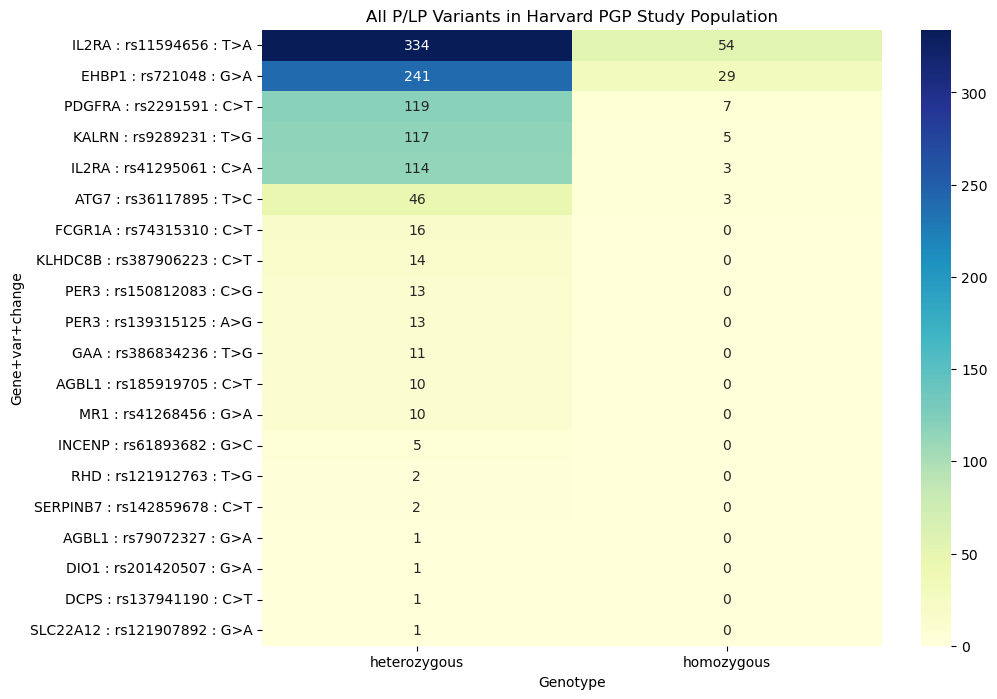

In [243]:
grouped = heatmap_data.groupby(["Gene+var+change", "genotype"]).size().reset_index(name="count")

# Reshape the data into a pivot table for heatmap
pivot_table = grouped.pivot_table(index="Gene+var+change", columns="genotype", values="count", fill_value=0)
pivot_table['count'] = pivot_table['heterozygous'] + pivot_table['homozygous']
pivot_table = pivot_table.sort_values(by='count', ascending=False)
pivot_table.drop(columns=['count'], inplace=True)
# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table,fmt='d', annot=True, cmap="YlGnBu")
plt.title("All P/LP Variants in Harvard PGP Study Population")
plt.xlabel("Genotype")
plt.ylabel("Gene+var+change")
plt.show()

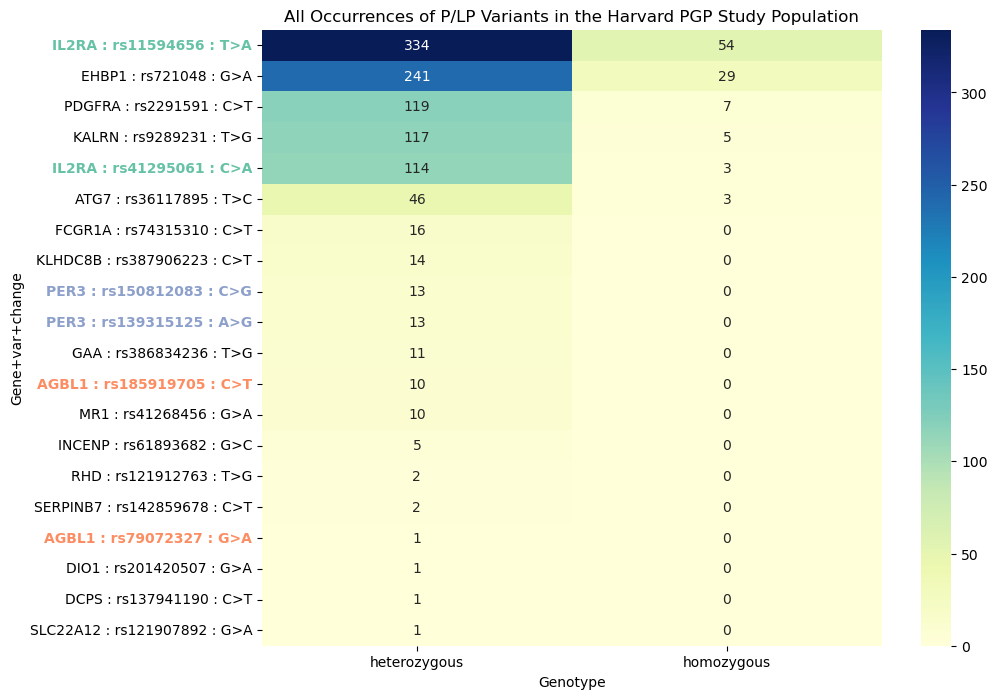

In [294]:
# Group and count occurrences
grouped = heatmap_data.groupby(["Gene+var+change", "genotype"]).size().reset_index(name="count")

# Reshape the data into a pivot table for heatmap
pivot_table = grouped.pivot_table(index="Gene+var+change", columns="genotype", values="count", fill_value=0)

# Calculate total count
pivot_table['count'] = pivot_table['heterozygous'] + pivot_table['homozygous']
pivot_table = pivot_table.sort_values(by='count', ascending=False)
pivot_table.drop(columns=['count'], inplace=True)

# Extract gene symbols
pivot_table["GeneSymbol"] = pivot_table.index.str.split(" : ").str[0]

# Gene symbols to assign unique colors
genes_to_color = ['IL2RA', 'AGBL1', 'PER3']

# Create the dictionary to map GeneSymbols to colors
gene_color_mapping = {}
color_palette = sns.color_palette("Set2")

for gene_symbol, color in zip(genes_to_color, color_palette):
    gene_color_mapping[gene_symbol] = color

# Create the heatmap using Seaborn with custom formatting and color-coded y-axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table.drop("GeneSymbol", axis=1), annot=True, fmt='d', cmap="YlGnBu")
plt.title("All Occurrences of P/LP Variants in the Harvard PGP Study Population")
plt.xlabel("Genotype")
plt.ylabel("Gene+var+change")

# Apply color coding to y-axis labels and make them bolder
ax = plt.gca()
y_labels = ax.get_yticklabels()

for label in y_labels:
    gene_symbol = label.get_text().split(" : ")[0]
    if gene_symbol in gene_color_mapping:
        label.set_color(gene_color_mapping[gene_symbol])
        label.set_fontweight('bold')  # Make the label text bold
    else:
        label.set_color('black')  # Set the color to black for GeneSymbols that don't match the unique colors

plt.show()